In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# going to the repository of this note book
%cd drive/My Drive/Thesis/CPNN_PiggyBack
!ls

/content/drive/My Drive/Thesis/CPNN_PiggyBack
data		     iris-model.pickle	performance	   requirements.txt  Untitled0.ipynb
datasets	     lab		push_to_git.ipynb  results
iris-model-full.pth  models		README.md	   run_test


In [ ]:
# IMPORT
import torch
import os
# this module is for training and functions related to data preparation
from models.training import *
from models.cpnn import *
# this is for importing pretrain models.
from models.pretrain import *

#from models.cpnn_others import cPNNExp
#from models.cpnn_seq import cPNNSeq
#from models.cgru_double import cGRULinearDouble
#from models.clstm import *

import torch.nn.functional as F
import numpy as np
import pandas as pd
import pickle
import argparse
from torch.autograd import Variable
import pprint
import copy


In [ ]:
# EDITABLE PARAMETERS
dataset = "sine_rw10_mode5_extended_6-6_1234"

# OTHER PARAMETERS
batch_size = 128
hidden_size = 50
seq_len = 10
# TODO
iterations = 1
loss_on_seq = False
freeze_inputs_weights = False
pretraining_samples = 0
pretraining_epochs = 0
write_weights = False
combination = False
model_type='LSTM'
if model_type == "GRU":
    model_class = GRU_Model
else:
    model_class = LSTM_Model

path = os.path.join(
    "performance/pretrain_GRU"
)

In [ ]:
df = pd.read_csv("datasets/datasets/sine_rw10_mode5_extended_6-6_1234.csv")
df_task = df[df["task"] == 1]
df_task = df_task.drop(columns="task")

In [ ]:
Model = GRU_Model(input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
          )
instance = cPNN(seq_len=seq_len)

In [ ]:
print(Model)

GRU_Model(
  (gru): GRU(2, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)


In [ ]:
if len(df_task) % batch_size == 0:
  n_batches = int(len(df_task) / batch_size)
else:
  n_batches = int(len(df_task) / batch_size) + 1
optimizer = torch.optim.Adam(Model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
out_h = None
for j in range(0,5):
  for i in range(0, len(df_task), batch_size):
    x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
    y = list(df_task.iloc[i : i + batch_size, -1])
    if len(y) >= seq_len:
      x = np.array(x)
      y = list(y)
      x, y, _ = instance._load_batch(x, y)
      y_pred = Model(x)
      y_pred = get_samples_outputs(y_pred)
      pred, _ = get_pred_from_outputs(y_pred)
      loss = loss_fn(y_pred, y)
      # backward pass
      optimizer.zero_grad()
      loss.backward()
      # update weights
      optimizer.step()


In [ ]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(Model.state_dict())

OrderedDict([   (   'lstm.weight_ih_l0',
                    tensor([[ 0.0940,  0.5334],
        [-0.2806, -0.1119],
        [ 0.1217, -0.2397],
        [-0.5723, -0.2680],
        [-0.0169, -0.8159],
        [-0.1738, -1.1156],
        [-0.8493,  0.6257],
        [-0.4154, -0.4050],
        [ 0.5962,  0.1079],
        [-1.7212, -0.6443],
        [ 0.0546,  0.4848],
        [-1.2478, -0.6111],
        [ 0.1779,  0.5854],
        [ 0.1799,  0.1041],
        [-0.4846, -0.3393],
        [-0.9674,  0.9914],
        [-0.0734, -0.3229],
        [-0.8556, -0.9040],
        [ 1.0917, -0.0275],
        [-0.9115, -0.5965],
        [-1.6037, -0.5963],
        [-0.7858, -0.1557],
        [-0.6617, -0.9690],
        [-0.0532,  0.1055],
        [-0.8107, -0.0084],
        [-0.6777, -0.5698],
        [ 0.9374, -0.1218],
        [-0.7218, -0.8534],
        [ 0.5856,  0.0232],
        [-0.9594, -0.7794],
        [ 0.0440,  0.7767],
        [-1.4085, -0.8374],
        [-0.5400, -0.6049],
        [-0.059

In [ ]:
# Save model
with open("performance/pretrain/pretrain_mode_lstm_sine_rw10_mode5_extended_6-6_1234_1.pickle", "wb") as fp:
    pickle.dump(Model.state_dict(), fp)

## trying to read the weights of the pretrain model

In [ ]:
pretrain_model = LSTM_Model(input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
          )
with open("performance/pretrain/pretrain_mode_lstm_sine_rw10_mode5_extended_6-6_1234_1.pickle", "rb") as fp:
    pretrain_model.load_state_dict(pickle.load(fp),strict=False)

In [ ]:
import statistics

In [ ]:
df = pd.read_csv("datasets/datasets/sine_rw10_mode5_extended_16-16_1234.csv")
for task in range(1, df["task"].max() + 1):
  acc=[]
  df_task = df[df["task"] == task]
  df_task = df_task.drop(columns="task")
  for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if len(y) >= seq_len:
        x = np.array(x)
        y = list(y)
        x, y, _ = instance._load_batch(x, y)
        y_pred = pretrain_model(x)
        y_pred = get_samples_outputs(y_pred)
        pred, _ = get_pred_from_outputs(y_pred)
        acc.append(accuracy_score(np.array(y),np.array(pred)))
  print(statistics.mean(acc))


0.35121882992327363
0.20711317135549873
0.6440776854219948
0.8104859335038364


In [ ]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(pretrain_model.state_dict())

OrderedDict([   (   'gru.weight_ih_l0',
                    tensor([[ 4.9395e-01,  7.2624e-01],
        [-2.5023e-01, -1.5779e+00],
        [ 4.2910e-02, -2.2821e-03],
        [-2.7951e-01, -9.4084e-02],
        [-4.2295e-01, -2.2655e-01],
        [-7.1322e-01, -6.1827e-01],
        [-1.0246e-02, -3.2005e-01],
        [-4.1410e-01, -1.2440e+00],
        [-7.2617e-01, -7.9609e-01],
        [-5.6529e-01, -9.9232e-01],
        [-5.3829e-01, -1.3724e+00],
        [-4.4110e-01, -1.1477e+00],
        [-4.6161e-01, -9.9819e-01],
        [-3.8753e-01,  8.9283e-01],
        [-6.3671e-01, -1.5068e+00],
        [-7.4016e-01, -1.4635e+00],
        [-2.6262e-01, -5.4108e-02],
        [-8.1440e-01, -1.1812e+00],
        [-2.4015e-01, -5.9275e-01],
        [-7.2938e-01, -1.5080e+00],
        [ 1.7937e-01,  2.7415e-01],
        [-4.2030e-01, -5.6660e-01],
        [-5.5590e-01, -5.9604e-01],
        [-5.3422e-01, -5.8739e-01],
        [-3.8810e-01,  2.8452e-01],
        [-9.4800e-02,  7.1795e-01],
    

In [ ]:
pretrain_model

LSTM_Model(
  (lstm): LSTM(2, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

In [ ]:
x = copy.deepcopy(pretrain_model.state_dict())
for param_name in x:
  print(param_name)
  print(x[param_name].shape)

lstm.weight_ih_l0
torch.Size([200, 2])
lstm.weight_hh_l0
torch.Size([200, 50])
lstm.bias_ih_l0
torch.Size([200])
lstm.bias_hh_l0
torch.Size([200])
linear.weight
torch.Size([2, 50])
linear.bias
torch.Size([2])


# Here first we need to train pure GRU or LSTM based models

In [ ]:
batch_size = 128
hidden_size = 50
seq_len = 10
epoch_size=5
mask_init='uniform'
dataset = "sine_rw10_mode5_extended_16-16_2341"
df = pd.read_csv(os.path.join("datasets/datasets", f"{dataset}.csv"))

number_of_tasks=4
instance = cPB(seq_len=seq_len)
pretrain_model = PretrainModel(
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=hidden_size,
        output_size=2,
        batch_size=batch_size,
          )
acc=[]
kappa=[]
optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
for task in range(1, df["task"].max() + 1):
  df_task = df[df["task"] == task]
  df_task = df_task.drop(columns="task")
  acc.append([])
  kappa.append([])
  for i in range(0, len(df_task), batch_size):
    x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
    y = list(df_task.iloc[i : i + batch_size, -1])
    if len(y) >= seq_len:
      x = np.array(x)
      y = list(y)
      x, y, _ = instance._load_batch(x, y)
      y_pred = pretrain_model(x)
      y_pred = get_samples_outputs(y_pred)
      pred, _ = get_pred_from_outputs(y_pred)
      acc[-1].append(accuracy_score(np.array(y),np.array(pred)))
      kappa[-1].append(cohen_kappa(y,pred).item())
      for j in range(0,5):
        loss = loss_fn(y_pred, y)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        y_pred = pretrain_model(x)
        y_pred = get_samples_outputs(y_pred)
        pred, _ = get_pred_from_outputs(y_pred)


In [ ]:
pd.DataFrame(acc).to_csv('results/acc-16_16-2341-puretrain.csv', index=False)
pd.DataFrame(kappa).to_csv('results/kappa-16_16-2341-puretrain.csv', index=False)

#**From now on, the part for adding mask will be implemented:**

##The first part is the implementing of the frozen pretrained model and then testing on test dataset.

In [ ]:
batch_size = 128
hidden_size = 50
seq_len = 10
epoch_size=5
mask_init='uniform'
dataset = "sine_rw10_mode5_extended_16-16_1234"
df = pd.read_csv(os.path.join("datasets/datasets", f"{dataset}.csv"))
pretrain_model_addr='performance/pretrain/pretrain_mode_gru_sine_rw10_mode5_extended_6-6_1234_4.pickle'

number_of_tasks=4
instance = cPB(seq_len=seq_len)
pretrain_model = PretrainModel(
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=hidden_size,
        output_size=2,
        batch_size=batch_size,
          )
with open(pretrain_model_addr, "rb") as fp:
    		    pretrain_model.load_state_dict(pickle.load(fp),strict=False)
acc=[]
kappa=[]
for task in range(1, df["task"].max() + 1):
  df_task = df[df["task"] == task]
  df_task = df_task.drop(columns="task")
  acc.append([])
  kappa.append([])
  for i in range(0, len(df_task), batch_size):
    x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
    y = list(df_task.iloc[i : i + batch_size, -1])
    if len(y) >= seq_len:
      x = np.array(x)
      y = list(y)
      x, y, _ = instance._load_batch(x, y)
      y_pred = pretrain_model(x)
      y_pred = get_samples_outputs(y_pred)
      pred, _ = get_pred_from_outputs(y_pred)
      acc[-1].append(accuracy_score(np.array(y),np.array(pred)))
      kappa[-1].append(cohen_kappa(y,pred).item())


In [ ]:
pd.DataFrame(acc).to_csv('results/acc-CPB-16_16-frozen-1234-t4.csv', index=False)
pd.DataFrame(kappa).to_csv('results/kappa-CPB-16_16-frozen-1234-t4.csv', index=False)

0    0.668472
1    0.700355
2    0.656562
3    0.812521
4    0.666689
dtype: float64
0    0.658617
1    0.674011
2    0.670207
3    0.794875
4    0.687306
dtype: float64
0    0.663672
1    0.640572
2    0.658128
3    0.719156
4    0.803571
dtype: float64
0    0.658728
1    0.641481
2    0.670671
3    0.705178
4    0.805178
dtype: float64


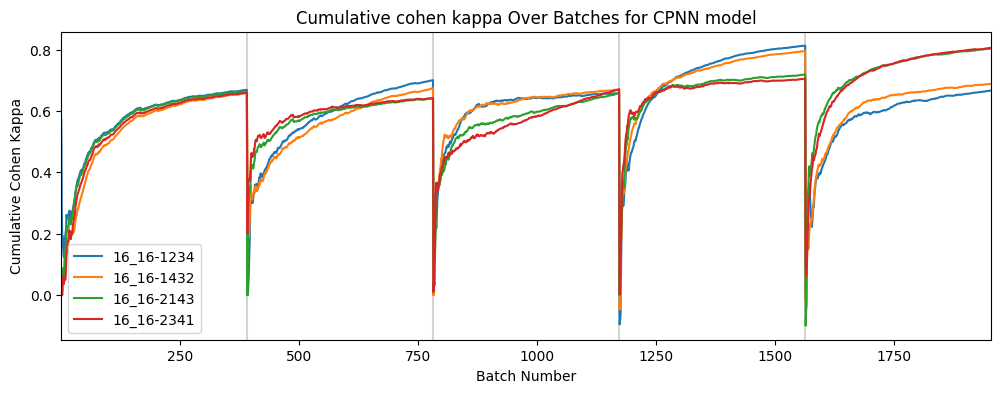

In [ ]:
df1 = np.array(pd.read_csv('results/kappa-cpnn-pretrain-t4-16_16-1234.csv'))
df2 = np.array(pd.read_csv('results/kappa-cpnn-pretrain-t4-16_16-1432.csv'))
df3 = np.array(pd.read_csv('results/kappa-cpnn-pretrain-t4-16_16-2143.csv'))
df4 = np.array(pd.read_csv('results/kappa-cpnn-pretrain-t4-16_16-2341.csv'))

def string_to_float(s):
    return float(s.strip('[]'))

# Apply the conversion function to each element in the array
df1 = pd.DataFrame(np.vectorize(string_to_float)(df1))
df2 = pd.DataFrame(np.vectorize(string_to_float)(df2))
df3 = pd.DataFrame(np.vectorize(string_to_float)(df3))
df4 = pd.DataFrame(np.vectorize(string_to_float)(df4))
# Create a DataFrame from the converted data
print( df1.mean(axis=1))
print( df2.mean(axis=1))
print( df3.mean(axis=1))
print( df4.mean(axis=1))

all_x=np.concatenate((df1,df2,df3,df4),axis=0)
y = np.cumsum(all_x, axis=1) / np.arange(1, all_x.shape[1] + 1)
vertical_lines_x = [all_x.shape[1], 2*all_x.shape[1], 3*all_x.shape[1],4*all_x.shape[1]]
x = list(range(1,5*all_x.shape[1] + 1))
fig, ax = plt.subplots(figsize=(12, 4))
ax.margins(x=0.0)
label_list=['16_16-1234','16_16-1432','16_16-2143','16_16-2341']

for i in vertical_lines_x:
  plt.axvline(x=i, color='#D3D3D3', linestyle='-')

for i in range(0,y.shape[0],5):
  ax.plot(x, np.concatenate((y[i],y[i+1],y[i+2],y[i+3],y[i+4]),axis=0), label= label_list[int(i/5)])
plt.xlabel('Batch Number')
plt.ylabel('Cumulative Cohen Kappa')
plt.title('Cumulative cohen kappa Over Batches for CPNN model')
plt.legend()
plt.show()

##Now we also train the pretrain model for each task of the test dataset.

list of accuracies that used for evaluating and selecting the models =  [0.5315625]
list of kappa values that used for evaluating and selecting the models =  [0.07300173]
index of selcted mask for this task 0
All batches Accuracy=  0.7782249040920716
All batches cohen kappa=  0.5543609421425278
list of accuracies that used for evaluating and selecting the models =  [0.6715625 0.7584375]
list of kappa values that used for evaluating and selecting the models =  [0.35117985 0.50220675]
index of selcted mask for this task 1
All batches Accuracy=  0.772258631713555
All batches cohen kappa=  0.5430718919695796
list of accuracies that used for evaluating and selecting the models =  [0.56046875 0.85203125 0.7721875 ]
list of kappa values that used for evaluating and selecting the models =  [0.10064061 0.70057199 0.53491207]
index of selcted mask for this task 1
All batches Accuracy=  0.8781010230179027
All batches cohen kappa=  0.7544710198250573
list of accuracies that used for evaluating and

All batches Accuracy=  0.7429987212276215
All batches cohen kappa=  0.48438810508893543


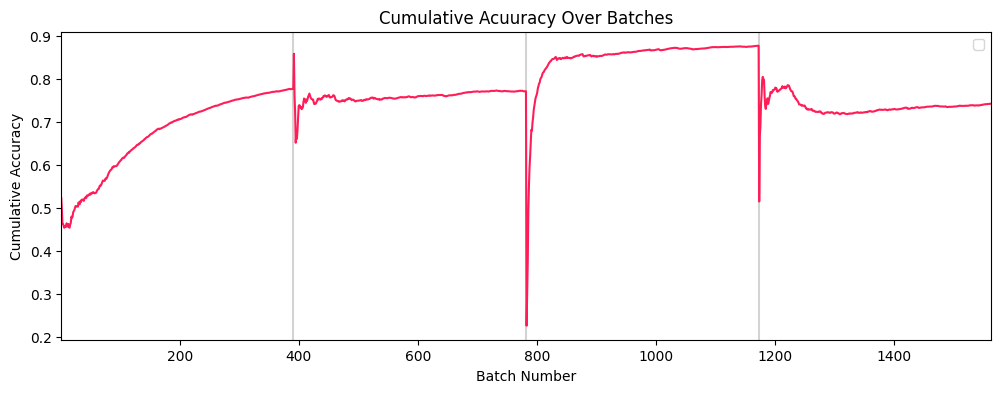

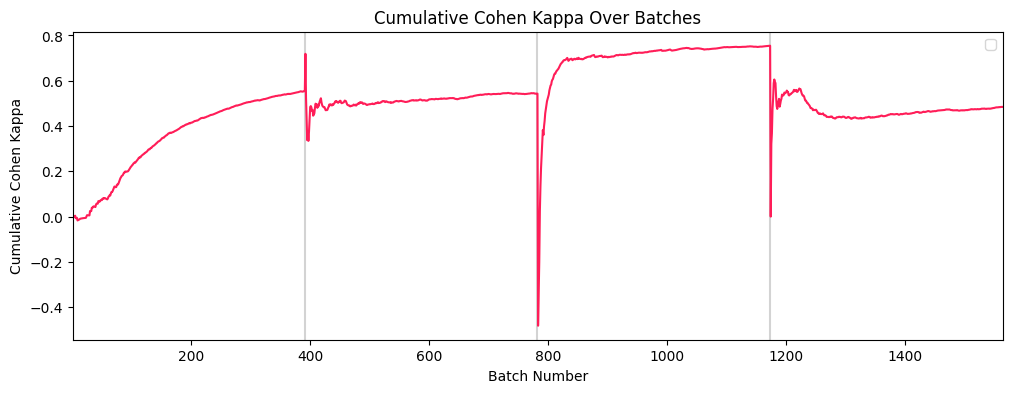

In [ ]:
batch_size = 128
hidden_size = 100
seq_len = 10
epoch_size=5
lr = 0.01
number_of_tasks=4
mask_selection_NofBatch = 50
threshold_fn = 'ternarizer'
mask_init='uniform'
dataset = "sine_rw10_mode5_extended_16-16_1234"
df = pd.read_csv(os.path.join("datasets/datasets", f"{dataset}.csv"))
pretrain_model_addr='performance/pretrain/pretrain_mode_gru_sine_rw10_mode5_extended_6-6_1234_1.pickle'
mask_weights=[]

model=cPB(model_class=PiggyBackGRU, lr = lr ,threshold_fn=threshold_fn, seq_len=seq_len, pretrain_model_addr=pretrain_model_addr,
           mask_weights=mask_weights, mask_init=mask_init, number_of_tasks=number_of_tasks,epoch_size=epoch_size)
iteration=1
# first loop for the iterations, for now it is just 1 iteration.
for iter in range(0,iteration):
  # loop for each task
  for task in range(1, df["task"].max() + 1):
    df_task = df[df["task"] == task]
    df_task = df_task.drop(columns="task")
    # loop based on each batch of data
    batch_cont=0
    model.weights_copy(task)
    for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if batch_cont<mask_selection_NofBatch:
        for mask_index in range (0, task):
          model.predict_many(x,y,mask_index)
          model.learn_many(x,y,mask_index)
        batch_cont+=1
      elif batch_cont==mask_selection_NofBatch:
        best_mask_index=model.add_new_column()
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
        batch_cont+=1
      elif batch_cont>mask_selection_NofBatch:
        batch_cont+=1
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
    model.save_final_metrics(task,best_mask_index)
    model.final_weights_saving()
  model.plotting()


list of accuracies that used for evaluating and selecting the models =  [0.59390625]
list of kappa values that used for evaluating and selecting the models =  [0.20385725]
index of selcted mask for this task 0
All batches Accuracy=  0.7983975383631713
All batches cohen kappa=  0.5964011445479549
list of accuracies that used for evaluating and selecting the models =  [0.68359375 0.77296875]
list of kappa values that used for evaluating and selecting the models =  [0.36795252 0.53103834]
index of selcted mask for this task 1
All batches Accuracy=  0.7745724104859336
All batches cohen kappa=  0.5472442772753937
list of accuracies that used for evaluating and selecting the models =  [0.54609375 0.7440625  0.75515625]
list of kappa values that used for evaluating and selecting the models =  [0.10194991 0.48030535 0.49111431]
index of selcted mask for this task 2
All batches Accuracy=  0.8178148976982097
All batches cohen kappa=  0.6312319592375051
list of accuracies that used for evaluating

All batches Accuracy=  0.7806265984654732
All batches cohen kappa=  0.5564204653858414


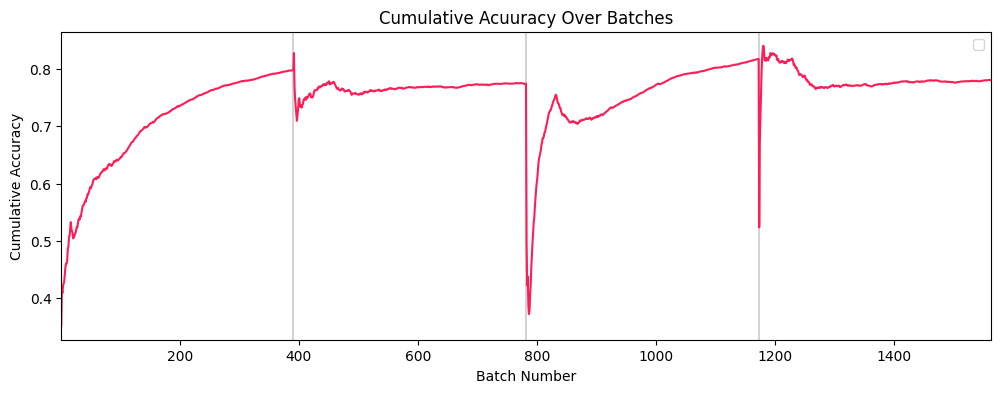

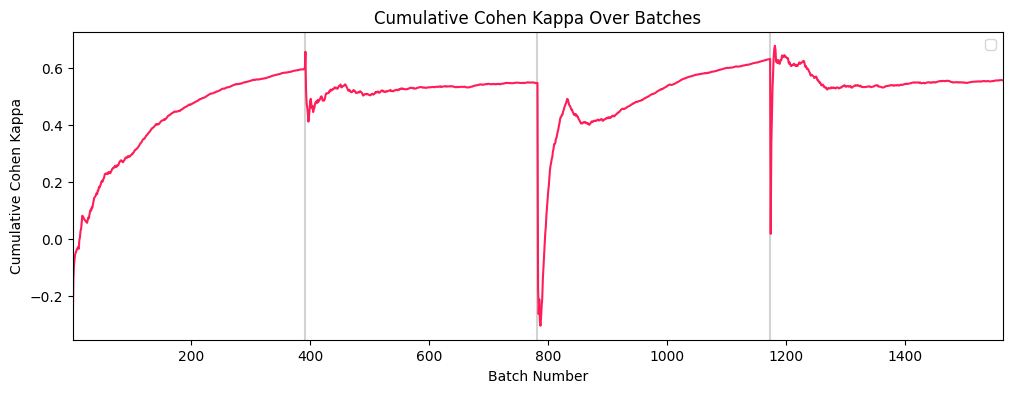

In [ ]:
batch_size = 128
hidden_size = 100
seq_len = 10
epoch_size=5
lr = 0.01
number_of_tasks=4
mask_selection_NofBatch = 50
threshold_fn = 'ternarizer'
mask_init='uniform'
dataset = "sine_rw10_mode5_extended_16-16_1234"
df = pd.read_csv(os.path.join("datasets/datasets", f"{dataset}.csv"))
pretrain_model_addr='performance/pretrain/pretrain_mode_gru_sine_rw10_mode5_extended_6-6_1234_3.pickle'
mask_weights=[]

model=cPB(model_class=PiggyBackGRU, lr = lr ,threshold_fn=threshold_fn, seq_len=seq_len, pretrain_model_addr=pretrain_model_addr,
           mask_weights=mask_weights, mask_init=mask_init, number_of_tasks=number_of_tasks,epoch_size=epoch_size)
iteration=1
# first loop for the iterations, for now it is just 1 iteration.
for iter in range(0,iteration):
  # loop for each task
  for task in range(1, df["task"].max() + 1):
    df_task = df[df["task"] == task]
    df_task = df_task.drop(columns="task")
    # loop based on each batch of data
    batch_cont=0
    model.weights_copy(task)
    for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if batch_cont<mask_selection_NofBatch:
        for mask_index in range (0, task):
          model.predict_many(x,y,mask_index)
          model.learn_many(x,y,mask_index)
        batch_cont+=1
      elif batch_cont==mask_selection_NofBatch:
        best_mask_index=model.add_new_column()
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
        batch_cont+=1
      elif batch_cont>mask_selection_NofBatch:
        batch_cont+=1
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
    model.save_final_metrics(task,best_mask_index)
    model.final_weights_saving()
  model.plotting()


In [ ]:
# done ---------------------------------------------------------------------------------
import torch
from torch import nn
import numpy as np


class GRU_Model(nn.Module):
    def __init__(
        self,
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
        many_to_one=False,
        remember_states = None,

    ):
        super(GRU_Model, self).__init__()

        # PARAMETERS
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = torch.device(device)
        self.remember_states = remember_states

        self.h0 = np.zeros((1, self.hidden_size))
        self.many_to_one = many_to_one

        # LAYERS
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.gru.to(self.device)
        self.linear = nn.Linear(hidden_size, output_size)
        self.linear.to(self.device)

    def forward(self, x, train=False):
        input_f = x.to(self.device)

        out_h, _ = self.gru(input_f,self._build_initial_state(x, self.h0))
        if self.many_to_one:
            out = self.linear(out_h[:,-1:,:])
        else:
            out = self.linear(out_h)

        if train and self.remember_states:
            self.h0 = out_h[:, 1, :].detach().numpy()
        return out

    def _build_initial_state(self, x, state):
        s = torch.from_numpy(np.tile(state, (1, x.size()[0], 1))).float()
        s.requires_grad = True
        return s.to(self.device)


class LSTM_Model(nn.Module):
    def __init__(
        self,
        input_size=2,
      	num_layers=1,
        device=torch.device("cpu"),
        hidden_size=50,
        output_size=2,
        batch_size=128,
        many_to_one=False,
        remember_states = None
    ):
        super(LSTM_Model, self).__init__()

        # PARAMETERS
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = torch.device(device)
        self.num_layers = num_layers
        self.h0 = np.zeros((1, self.hidden_size))
        self.c0 = np.zeros((1, self.hidden_size))
        self.many_to_one = many_to_one

        # LAYERS
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        self.lstm.to(self.device)

        self.linear = nn.Linear(hidden_size, output_size)
        self.linear.to(self.device)

    def forward(self, x, train=False):
        input_f = x.to(self.device)

        out_h, _ = self.lstm(
            input_f,
            (
                self._build_initial_state(x, self.h0),
                self._build_initial_state(x, self.c0),
            ),
        )
        if self.many_to_one:
            out = self.linear(out_h[:,-1:,:])[:,-1,:]
        else:
            out = self.linear(out_h)

        return out

    def _build_initial_state(self, x, state):
        s = torch.from_numpy(np.tile(state, (1, x.size()[0], 1))).float()
        s.requires_grad = True
        return s.to(self.device)

In [ ]:
# this file is for defining the piggyback layers with mask
# Done -------------------------------------------------------------------------------
import torch
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score
import warnings
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.modules.utils import _pair
from torch.nn.parameter import Parameter
# importing gru math computation block
from torch._VF import gru as _VF_gru
from torch._VF import lstm as _VF_lstm

DEFAULT_THRESHOLD = 5e-3
class Binarizer(torch.autograd.Function):
    """Binarizes {0, 1} a real valued tensor."""

    def __init__(self, threshold=DEFAULT_THRESHOLD):

        super(Binarizer, self).__init__()
        Binarizer.threshold = threshold

    def forward(self, inputs):
        outputs = inputs.clone()
        outputs[inputs.le(Binarizer.threshold)] = 0
        outputs[inputs.gt(Binarizer.threshold)] = 1
        #print(outputs)
        return outputs

    def backward(self, gradOutput):
        return gradOutput

class Ternarizer(torch.autograd.Function):
    """Ternarizes {-1, 0, 1} a real valued tensor."""

    def __init__(self, threshold=DEFAULT_THRESHOLD):

        super(Ternarizer, self).__init__()
        Ternarizer.threshold = threshold

    def forward(self, inputs):
        outputs = inputs.clone()
        outputs.fill_(0)
        outputs[inputs < 0] = -1
        outputs[inputs > Ternarizer.threshold] = 1
        return outputs

    def backward(self, gradOutput):
        return gradOutput

def GRUBlockMath(input, hn, weight_thresholded_ih, weight_thresholded_hh, bias_ih_l0,
              bias_hh_l0, batch_size=None, bias=True, num_layers=1, dropout=0.0, training=False, bidirectional= False, batch_first=False):

  #print(weight_thresholded_ih)
  tensors = [weight_thresholded_ih,
             weight_thresholded_hh,
             bias_ih_l0,
             bias_hh_l0]
  #batch_size = torch.tensor(batch_size)
  batch_size= None
  if batch_size==None:
    output, new_hn = _VF_gru(input, hn, tensors, bias, num_layers, dropout, training, bidirectional, batch_first )
  else:
    output, new_hn = _VF_gru(input, batch_size, hn, tensors, bias, num_layers, dropout, training, bidirectional )
  return output, new_hn

def LSTMBlockMath(input, hn, weight_thresholded_ih, weight_thresholded_hh, bias_ih_l0,
              bias_hh_l0, batch_size=None, bias=True, num_layers=1, dropout=0.0, training=False, bidirectional= False, batch_first=False):

  #print(weight_thresholded_ih)
  tensors = [weight_thresholded_ih,
             weight_thresholded_hh,
             bias_ih_l0,
             bias_hh_l0]
  #batch_size = torch.tensor(batch_size)
  batch_size= None
  if batch_size==None:
    results = _VF_lstm(input, hn, tensors, bias, num_layers, dropout, training, bidirectional, batch_first )
  else:
    results = _VF_lstm(input, batch_size, hn, tensors, bias, num_layers, dropout, training, bidirectional )
  output=results[0]
  return output

class ElementWiseLSTM(nn.Module):
    """Modified linear layer."""
    def __init__(
        self,
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
        many_to_one=False,
        remember_states = None,
        bias=True,
        dropout=0.0,
        # this variable should be asked from TA
        training=False,
        bidirectional=False,
        batch_first=True,
        mask_init='uniform',
        mask_scale=1e-2,
        threshold_fn='binarizer',
      	threshold=None,
      	LSTM_weights=[],
        seq_len=10,
        LSTM_mask_weights=[]
    ):
        super(ElementWiseLSTM, self).__init__()

        # PARAMETERS
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = torch.device(device)
        self.bias=bias
        self.dropout=dropout
        self.training=training
        self.bidirectional=bidirectional
        self.batch_first=batch_first
        self.mask_init = mask_init
        self.mask_scale = mask_scale
        self.threshold_fn = threshold_fn
        self.threshold=threshold
        self.LSTM_weights=LSTM_weights
        self.seq_len=seq_len,
        self.LSTM_mask_weights=LSTM_mask_weights

        # this hn should be defined at the begining and will be updated during the training.
        # I should ask from TA about configuration of hn. if it needed to be updated after each batch or it initialized to zero each iteration
        #self.h0 = torch.randn((num_layers, seq_len, self.hidden_size))
        #self.c0 = torch.rand((num_layers, seq_len, self.hidden_size))
        #hx = (self.hn, self.c0)

        if threshold is None:
            threshold = DEFAULT_THRESHOLD
        self.info = {
            'threshold_fn': threshold_fn,
            'threshold': threshold,
        }

        # weight and bias are no longer Parameters.
        self.weight_ih = Variable(torch.Tensor(
            4*hidden_size, input_size), requires_grad=False)
        self.weight_hh = Variable(torch.Tensor(
            4*hidden_size, hidden_size), requires_grad=False)

        self.bias_ih_l0 = Variable(torch.Tensor(
            4*hidden_size), requires_grad=False)
        self.bias_hh_l0 = Variable(torch.Tensor(
            4*hidden_size), requires_grad=False)

        self.weight_ih=LSTM_weights[0]
        self.weight_hh=LSTM_weights[1]
        self.bias_ih_l0=LSTM_weights[2]
        self.bias_hh_l0=LSTM_weights[3]
        # Initialize real-valued mask weights.
        self.mask_real_weight_ih = self.weight_ih.data.new(self.weight_ih.size())
        self.mask_real_weight_hh = self.weight_hh.data.new(self.weight_hh.size())
        self.mask_real_bias_ih = self.weight_ih.data.new(self.bias_ih_l0.size())
        self.mask_real_bias_hh = self.weight_hh.data.new(self.bias_hh_l0.size())
        self.h0 = np.zeros((1, self.hidden_size))
        self.c0 = np.zeros((1, self.hidden_size))
        if mask_init == '1s':
            self.mask_real_weight_ih.fill_(mask_scale)
            self.mask_real_weight_hh.fill_(mask_scale)
            self.mask_real_bias_ih.fill_(mask_scale)
            self.mask_real_bias_hh.fill_(mask_scale)
        elif mask_init == 'uniform':
            self.mask_real_weight_ih.uniform_(-1 * mask_scale, mask_scale)
            self.mask_real_weight_hh.uniform_(-1 * mask_scale, mask_scale)
            self.mask_real_bias_ih.uniform_(-1 * mask_scale, mask_scale)
            self.mask_real_bias_hh.uniform_(-1 * mask_scale, mask_scale)
        if LSTM_mask_weights!=[]:
            self.mask_real_weight_ih = Parameter(self.LSTM_mask_weights[0])
            self.mask_real_weight_hh = Parameter(self.LSTM_mask_weights[1])
            self.mask_real_bias_ih = Parameter(self.LSTM_mask_weights[2])
            self.mask_real_bias_hh = Parameter(self.LSTM_mask_weights[3])

        else:
            self.mask_real_weight_ih = Parameter(self.mask_real_weight_ih)
            self.mask_real_weight_hh = Parameter(self.mask_real_weight_hh)
            self.mask_real_bias_ih = Parameter(self.mask_real_bias_ih)
            self.mask_real_bias_hh = Parameter(self.mask_real_bias_hh)


        if threshold_fn == 'binarizer':
            self.threshold_fn = Binarizer(threshold=threshold)
        elif threshold_fn == 'ternarizer':
            self.threshold_fn = Ternarizer(threshold=threshold)

    def forward(self,input):
        if torch.isnan(self.mask_real_weight_ih).any():
            print('NaN exists ............................................')
            #print(self.mask_real_weight_ih)
            if self.mask_init == 'uniform':
                self.mask_real_weight_ih.uniform_(-1 * self.mask_scale, self.mask_scale)
                self.mask_real_weight_hh.uniform_(-1 * self.mask_scale, self.mask_scale)
            self.mask_real_weight_ih = Parameter(self.mask_real_weight_ih)
            self.mask_real_weight_hh = Parameter(self.mask_real_weight_hh)

        # Get binarized/ternarized mask from real-valued mask.

        mask_thresholded_ih = self.threshold_fn.apply(self.mask_real_weight_ih)
        mask_thresholded_hh = self.threshold_fn.apply(self.mask_real_weight_hh)
        mask_thresholded_bias_ih = self.threshold_fn.apply(self.mask_real_bias_ih)
        mask_thresholded_bias_hh = self.threshold_fn.apply(self.mask_real_bias_hh)
        self.hn=self._build_initial_state(input, self.h0)
        self.cn=self._build_initial_state(input, self.c0)
        self.hx=(self.hn,self.cn)
        # Mask weights with above mask.
        weight_thresholded_ih = mask_thresholded_ih * self.weight_ih
        weight_thresholded_hh = mask_thresholded_hh * self.weight_hh
        weight_thresholded_bias_ih = mask_thresholded_bias_ih * self.bias_ih_l0
        weight_thresholded_bias_hh = mask_thresholded_bias_hh * self.bias_hh_l0

        out = LSTMBlockMath(input, self.hx, weight_thresholded_ih, weight_thresholded_hh,
                                weight_thresholded_bias_ih, weight_thresholded_bias_hh, self.batch_size, self.bias, self.num_layers, self.dropout,
                                self.training, self.bidirectional, self.batch_first)
        # Get output using modified weight.

        return out
    def _build_initial_state(self, x, state):
        s = torch.from_numpy(np.tile(state, (1, x.size()[0], 1))).float()
        s.requires_grad = True
        return s.to(self.device)

    def _apply(self, fn):
        for module in self.children():
            module._apply(fn)

        for param in self._parameters.values():
            if param is not None:
                # Variables stored in modules are graph leaves, and we don't
                # want to create copy nodes, so we have to unpack the data.
                param.data = fn(param.data)
                if param._grad is not None:
                    param._grad.data = fn(param._grad.data)

        for key, buf in self._buffers.items():
            if buf is not None:
                self._buffers[key] = fn(buf)

        self.weight_ih.data = fn(self.weight_ih.data)
        self.weight_hh.data = fn(self.weight_hh.data)
        self.bias_ih_l0.data = fn(self.bias_ih_l0.data)
        self.bias_hh_l0.data = fn(self.bias_ih_l0.data)
        #if self.bias is not None and self.bias_ih_l0.data is not None:
        #    self.bias_ih_l0.data = fn(self.bias_ih_l0.data)
        #if self.bias is not None and self.bias_hh_l0.data is not None:
        #    self.bias_hh_l0.data = fn(self.bias_hh_l0.data)


class ElementWiseGRU(nn.Module):
    """Modified linear layer."""
    def __init__(
        self,
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
        many_to_one=False,
        remember_states = None,
        bias=True,
        dropout=0.0,
        # this variable should be asked from TA
        training=False,
        bidirectional=False,
        batch_first=True,
        mask_init='uniform',
        mask_scale=1e-2,
        threshold_fn='binarizer',
      	threshold=None,
      	GRU_weights=[],
        seq_len=10,
        GRU_mask_weights=[]
    ):
        super(ElementWiseGRU, self).__init__()

        # PARAMETERS
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = torch.device(device)
        self.bias=bias
        self.dropout=dropout
        self.training=training
        self.bidirectional=bidirectional
        self.batch_first=batch_first
        self.mask_init = mask_init
        self.mask_scale = mask_scale
        self.threshold_fn = threshold_fn
        self.threshold=threshold
        self.GRU_weights=GRU_weights
        self.seq_len=seq_len,
        self.GRU_mask_weights=GRU_mask_weights

        # this hn should be defined at the begining and will be updated during the training.
        # I should ask from TA about configuration of hn. if it needed to be updated after each batch or it initialized to zero each iteration

        self.h0 = np.zeros((1, self.hidden_size))

        if threshold is None:
            threshold = DEFAULT_THRESHOLD
        self.info = {
            'threshold_fn': threshold_fn,
            'threshold': threshold,
        }

        # weight and bias are no longer Parameters.
        self.weight_ih = Variable(torch.Tensor(
            3*hidden_size, input_size), requires_grad=False)
        self.weight_hh = Variable(torch.Tensor(
            3*hidden_size, hidden_size), requires_grad=False)

        self.bias_ih_l0 = Variable(torch.Tensor(
            3*hidden_size), requires_grad=False)
        self.bias_hh_l0 = Variable(torch.Tensor(
            3*hidden_size), requires_grad=False)

        self.weight_ih=GRU_weights[0]
        self.weight_hh=GRU_weights[1]
        self.bias_ih_l0=GRU_weights[2]
        self.bias_hh_l0=GRU_weights[3]
        # Initialize real-valued mask weights.
        self.mask_real_weight_ih = self.weight_ih.data.new(self.weight_ih.size())
        self.mask_real_weight_hh = self.weight_hh.data.new(self.weight_hh.size())
        self.mask_real_bias_ih = self.weight_ih.data.new(self.bias_ih_l0.size())
        self.mask_real_bias_hh = self.weight_hh.data.new(self.bias_hh_l0.size())
        if mask_init == '1s':
            self.mask_real_weight_ih.fill_(mask_scale)
            self.mask_real_weight_hh.fill_(mask_scale)
            self.mask_real_bias_ih.fill_(mask_scale)
            self.mask_real_bias_hh.fill_(mask_scale)
        elif mask_init == 'uniform':
            self.mask_real_weight_ih.uniform_(-1 * mask_scale, mask_scale)
            self.mask_real_weight_hh.uniform_(-1 * mask_scale, mask_scale)
            self.mask_real_bias_ih.uniform_(-1 * mask_scale, mask_scale)
            self.mask_real_bias_hh.uniform_(-1 * mask_scale, mask_scale)
        if GRU_mask_weights!=[]:
            self.mask_real_weight_ih = Parameter(self.GRU_mask_weights[0])
            self.mask_real_weight_hh = Parameter(self.GRU_mask_weights[1])
            self.mask_real_bias_ih = Parameter(self.GRU_mask_weights[2])
            self.mask_real_bias_hh = Parameter(self.GRU_mask_weights[3])

        else:
            self.mask_real_weight_ih = Parameter(self.mask_real_weight_ih)
            self.mask_real_weight_hh = Parameter(self.mask_real_weight_hh)
            self.mask_real_bias_ih = Parameter(self.mask_real_bias_ih)
            self.mask_real_bias_hh = Parameter(self.mask_real_bias_hh)


        if threshold_fn == 'binarizer':
            self.threshold_fn = Binarizer(threshold=threshold)
        elif threshold_fn == 'ternarizer':
            self.threshold_fn = Ternarizer(threshold=threshold)

    def forward(self,input):
        if torch.isnan(self.mask_real_weight_ih).any():
            print('NaN exists ............................................')
            #print(self.mask_real_weight_ih)
            if self.mask_init == 'uniform':
                self.mask_real_weight_ih.uniform_(-1 * self.mask_scale, self.mask_scale)
                self.mask_real_weight_hh.uniform_(-1 * self.mask_scale, self.mask_scale)
            self.mask_real_weight_ih = Parameter(self.mask_real_weight_ih)
            self.mask_real_weight_hh = Parameter(self.mask_real_weight_hh)

        # Get binarized/ternarized mask from real-valued mask.
        self.hn=self._build_initial_state(input, self.h0)
        mask_thresholded_ih = self.threshold_fn.apply(self.mask_real_weight_ih)
        mask_thresholded_hh = self.threshold_fn.apply(self.mask_real_weight_hh)
        mask_thresholded_bias_ih = self.threshold_fn.apply(self.mask_real_bias_ih)
        mask_thresholded_bias_hh = self.threshold_fn.apply(self.mask_real_bias_hh)

        # Mask weights with above mask.
        weight_thresholded_ih = mask_thresholded_ih * self.weight_ih
        weight_thresholded_hh = mask_thresholded_hh * self.weight_hh
        weight_thresholded_bias_ih = mask_thresholded_bias_ih * self.bias_ih_l0
        weight_thresholded_bias_hh = mask_thresholded_bias_hh * self.bias_hh_l0

        out,_ = GRUBlockMath(input, self.hn, weight_thresholded_ih, weight_thresholded_hh,
                                weight_thresholded_bias_ih, weight_thresholded_bias_hh, self.batch_size, self.bias, self.num_layers, self.dropout,
                                self.training, self.bidirectional, self.batch_first)
        # Get output using modified weight.

        return out
    def _build_initial_state(self, x, state):
        s = torch.from_numpy(np.tile(state, (1, x.size()[0], 1))).float()
        s.requires_grad = True
        return s.to(self.device)

    def _apply(self, fn):
        for module in self.children():
            module._apply(fn)

        for param in self._parameters.values():
            if param is not None:
                # Variables stored in modules are graph leaves, and we don't
                # want to create copy nodes, so we have to unpack the data.
                param.data = fn(param.data)
                if param._grad is not None:
                    param._grad.data = fn(param._grad.data)

        for key, buf in self._buffers.items():
            if buf is not None:
                self._buffers[key] = fn(buf)

        self.weight_ih.data = fn(self.weight_ih.data)
        self.weight_hh.data = fn(self.weight_hh.data)
        self.bias_ih_l0.data = fn(self.bias_ih_l0.data)
        self.bias_hh_l0.data = fn(self.bias_ih_l0.data)
        #if self.bias is not None and self.bias_ih_l0.data is not None:
        #    self.bias_ih_l0.data = fn(self.bias_ih_l0.data)
        #if self.bias is not None and self.bias_hh_l0.data is not None:
        #    self.bias_hh_l0.data = fn(self.bias_hh_l0.data)


class ElementWiseLinear(nn.Module):
    """Modified linear layer."""

    def __init__(
        self,
        in_features,
        out_features,
        bias=True,
        mask_init='uniform',
        mask_scale=1e-2,
        threshold_fn='binarizer',
        threshold=None,
        linear_weights=[],
        Linear_mask_weights=[]
        ):
        super(ElementWiseLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.threshold_fn = threshold_fn
        self.mask_scale = mask_scale
        self.mask_init = mask_init
        self.linear_weights=linear_weights
        self.Linear_mask_weights=Linear_mask_weights
        if threshold is None:
            threshold = DEFAULT_THRESHOLD
        self.info = {
            'threshold_fn': threshold_fn,
            'threshold': threshold,
        }

        # weight and bias are no longer Parameters.
        self.weight = Variable(torch.Tensor(
            out_features, in_features), requires_grad=False)
        if bias:
            self.bias = Variable(torch.Tensor(
                out_features), requires_grad=False)
        else:
            self.register_parameter('bias', None)
        self.weight=linear_weights[0]
        self.bias=linear_weights[1]
        # Initialize real-valued mask weights.
        self.mask_real_linear = self.weight.data.new(self.weight.size())
        if mask_init == '1s':
            self.mask_real_linear.fill_(mask_scale)
        elif mask_init == 'uniform':
            self.mask_real_linear.uniform_(-1 * mask_scale, mask_scale)
        # mask_real_linear is now a trainable parameter.
        if Linear_mask_weights!=[]:
            self.mask_real_linear = Parameter(self.Linear_mask_weights)
        else:
            self.mask_real_linear = Parameter(self.mask_real_linear)
        # Initialize the thresholder.
        if threshold_fn == 'binarizer':
            self.threshold_fn = Binarizer(threshold=threshold)
        elif threshold_fn == 'ternarizer':
            self.threshold_fn = Ternarizer(threshold=threshold)

    def forward(self, input):
        # Get binarized/ternarized mask from real-valued mask.
        mask_thresholded = self.threshold_fn.apply(self.mask_real_linear)
        # Mask weights with above mask.
        weight_thresholded = mask_thresholded * self.weight
        # Get output using modified weight.
        return F.linear(input, weight_thresholded, self.bias)

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'in_features=' + str(self.in_features) \
            + ', out_features=' + str(self.out_features) + ')'

    def _apply(self, fn):
        for module in self.children():
            module._apply(fn)

        for param in self._parameters.values():
            if param is not None:
                # Variables stored in modules are graph leaves, and we don't
                # want to create copy nodes, so we have to unpack the data.
                param.data = fn(param.data)
                if param._grad is not None:
                    param._grad.data = fn(param._grad.data)

        for key, buf in self._buffers.items():
            if buf is not None:
                self._buffers[key] = fn(buf)

        self.weight.data = fn(self.weight.data)
        self.bias.data = fn(self.bias.data)

In [ ]:
# this file is for Main network that contains piggyback layers with masks.
# here we just
# Done -------------------------------------------------------------------------------------
import torch
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score
import warnings
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.modules.utils import _pair
from torch.nn.parameter import Parameter
#import models.piggyback_layers as nl


class PiggyBackGRU(nn.Module):
    def __init__(
        self,
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
        many_to_one=False,
        remember_states = None,
        bias=True,
        dropout=0.0,
        # this variable should be asked from TA
        training=False,
        bidirectional=False,
        batch_first=False,
        mask_init='uniform',
      	mask_scale=1e-2,
        threshold_fn='binarizer',
      	threshold=None,
      	all_weights=[],
        seq_len=10,
        mask_weights=[]
        ):
        super(PiggyBackGRU, self).__init__()

        # PARAMETERS
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = torch.device(device)
        self.threshold_fn = threshold_fn
        self.mask_scale = mask_scale
        self.mask_init = mask_init
        self.all_weights=all_weights
        self.seq_len=seq_len
        self.mask_weights=mask_weights

        self.gru_weight_ih_l0=all_weights['gru.weight_ih_l0']
        self.gru_weight_hh_l0=all_weights['gru.weight_hh_l0']
        self.gru_bias_ih_l0=all_weights['gru.bias_ih_l0']
        self.gru_bias_hh_l0=all_weights['gru.bias_hh_l0']
        self.linear_weight=all_weights['linear.weight']
        self.linear_bias=all_weights['linear.bias']
        self.GRU_weights=[self.gru_weight_ih_l0,
           		   self.gru_weight_hh_l0,
           		   self.gru_bias_ih_l0,
           		   self.gru_bias_hh_l0]

        self.linear_weights=[
          			self.linear_weight,
          			self.linear_bias]
        if mask_weights!=[]:
            self.GRU_mask_weights=mask_weights[0:4]
            self.Linear_mask_weights=mask_weights[-1]
        else:
            self.GRU_mask_weights=[]
            self.Linear_mask_weights=[]
        # define nn network here

        self.classifier = nn.Sequential(
            ElementWiseGRU(input_size=input_size, device=device, num_layers=num_layers, hidden_size=hidden_size, bias=bias, dropout=dropout,
                bidirectional=bidirectional, training=training, mask_init=mask_init,
                mask_scale=mask_scale, threshold_fn=threshold_fn, threshold=threshold,
                GRU_weights=self.GRU_weights, seq_len=self.seq_len, GRU_mask_weights=self.GRU_mask_weights),

            ElementWiseLinear(in_features=hidden_size, out_features=output_size,
                mask_init=mask_init, mask_scale=mask_scale, threshold_fn=threshold_fn,
				threshold=threshold, linear_weights=self.linear_weights, Linear_mask_weights=self.Linear_mask_weights)
        )


    def forward(self,input):
        out = self.classifier(input)
        return out



class PiggyBackLSTM(nn.Module):
    def __init__(
        self,
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
        many_to_one=False,
        remember_states = None,
        bias=True,
        dropout=0.0,
        # this variable should be asked from TA
        training=False,
        bidirectional=False,
        batch_first=False,
        mask_init='uniform',
      	mask_scale=1e-2,
        threshold_fn='binarizer',
      	threshold=None,
      	all_weights=[],
        seq_len=10,
        mask_weights=[]
        ):
        super(PiggyBackLSTM, self).__init__()

        # PARAMETERS
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = torch.device(device)
        self.threshold_fn = threshold_fn
        self.mask_scale = mask_scale
        self.mask_init = mask_init
        self.all_weights=all_weights
        self.seq_len=seq_len
        self.mask_weights=mask_weights

        self.lstm_weight_ih_l0=all_weights['lstm.weight_ih_l0']
        self.lstm_weight_hh_l0=all_weights['lstm.weight_hh_l0']
        self.lstm_bias_ih_l0=all_weights['lstm.bias_ih_l0']
        self.lstm_bias_hh_l0=all_weights['lstm.bias_hh_l0']
        self.linear_weight=all_weights['linear.weight']
        self.linear_bias=all_weights['linear.bias']
        self.LSTM_weights=[self.lstm_weight_ih_l0,
           		   self.lstm_weight_hh_l0,
           		   self.lstm_bias_ih_l0,
           		   self.lstm_bias_hh_l0]

        self.linear_weights=[
          			self.linear_weight,
          			self.linear_bias]
        if mask_weights!=[]:
            self.LSTM_mask_weights=mask_weights[0:4]
            self.Linear_mask_weights=mask_weights[-1]
        else:
            self.LSTM_mask_weights=[]
            self.Linear_mask_weights=[]
        # define nn network here

        self.classifier = nn.Sequential(
            ElementWiseLSTM(input_size=input_size, device=device, num_layers=num_layers, hidden_size=hidden_size, bias=bias, dropout=dropout,
                bidirectional=bidirectional, training=training, mask_init=mask_init,
                mask_scale=mask_scale, threshold_fn=threshold_fn, threshold=threshold,
                LSTM_weights=self.LSTM_weights, seq_len=self.seq_len, LSTM_mask_weights=self.LSTM_mask_weights),

            ElementWiseLinear(in_features=hidden_size, out_features=output_size,
                mask_init=mask_init, mask_scale=mask_scale, threshold_fn=threshold_fn,
				threshold=threshold, linear_weights=self.linear_weights, Linear_mask_weights=self.Linear_mask_weights)
        )


    def forward(self,input):
        out = self.classifier(input)
        return out

In [ ]:
# first we need to load the pretrain model and then transfer the weights to the our impelemnted network.
# Done-----------------------------------------------------------------------------------------
import torch
import numpy as np
import warnings
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.modules.utils import _pair
from torch.nn.parameter import Parameter
#from models.pretrain import *
#from models.PiggyBack import *
import pickle
class ModifiedRNN(nn.Module):
    def __init__(
        self,
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
        base_model='gru',
        many_to_one=False,
        remember_states = None,
        bias=True,
        dropout=0.0,
        # this variable should be asked from TA
        training=False,
        bidirectional=False,
        batch_first=False,
        mask_init='unifrom',
      	mask_scale=1e-2,
        threshold_fn='binarizer',
      	threshold=None,
      	pretrain_model_addr='',
        seq_len=10,
        mask_weights=[]
    ):
        super(ModifiedRNN, self).__init__()


        # PARAMETERS
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = torch.device(device)
        self.threshold_fn = threshold_fn
        self.mask_scale = mask_scale
        self.mask_init = mask_init
        self.pretrain_model_addr=pretrain_model_addr
        self.seq_len=seq_len
        self.mask_weights=mask_weights
        self.base_model=base_model
        if base_model == 'gru':
            self.pretrain_model = GRU_Model(
            input_size=input_size,
            device=torch.device("cpu"),
      	    num_layers=num_layers,
            hidden_size=hidden_size,
            output_size=output_size,
            batch_size=batch_size,
              )
        else:
            self.pretrain_model = LSTM_Model(
            input_size=input_size,
            device=torch.device("cpu"),
      	    num_layers=num_layers,
            hidden_size=hidden_size,
            output_size=output_size,
            batch_size=batch_size,
              )

        with open(self.pretrain_model_addr, "rb") as fp:
    		    self.pretrain_model.load_state_dict(pickle.load(fp),strict=False)
        self.all_weights=self.pretrain_model.state_dict()
        if base_model =='gru':
            self.classifier=PiggyBackGRU(input_size=input_size, device=device,
                               num_layers=num_layers, hidden_size=hidden_size,
                               output_size=output_size, batch_size=batch_size,
                               many_to_one=many_to_one,remember_states=remember_states,
                               bias=bias, training=training, dropout=dropout,
                               bidirectional=bidirectional, batch_first=batch_first,
                               mask_init=mask_init, mask_scale=mask_scale,
                               threshold_fn=threshold_fn, threshold=threshold,
                               all_weights=self.all_weights,seq_len=seq_len, mask_weights=mask_weights
                               )
        else:
            self.classifier=PiggyBackLSTM(input_size=input_size, device=device,
                               num_layers=num_layers, hidden_size=hidden_size,
                               output_size=output_size, batch_size=batch_size,
                               many_to_one=many_to_one,remember_states=remember_states,
                               bias=bias, training=training, dropout=dropout,
                               bidirectional=bidirectional, batch_first=batch_first,
                               mask_init=mask_init, mask_scale=mask_scale,
                               threshold_fn=threshold_fn, threshold=threshold,
                               all_weights=self.all_weights,seq_len=seq_len, mask_weights=mask_weights
                               )


    def forward(self,input):
        out = self.classifier(input)
        return out

list of accuracies that used for evaluating and selecting the models =  [0.67078125]
list of kappa values that used for evaluating and selecting the models =  [0.37312482]
index of selcted mask for this task 0
All batches Accuracy=  0.849704283887468
All batches cohen kappa=  0.7018445831773531
list of accuracies that used for evaluating and selecting the models =  [0.69953125 0.751875  ]
list of kappa values that used for evaluating and selecting the models =  [0.3965395  0.48756953]
index of selcted mask for this task 1
All batches Accuracy=  0.7933264066496164
All batches cohen kappa=  0.5842616425022064
list of accuracies that used for evaluating and selecting the models =  [0.7109375 0.8565625 0.8490625]
list of kappa values that used for evaluating and selecting the models =  [0.43034452 0.70716573 0.68878413]
index of selcted mask for this task 1
All batches Accuracy=  0.8674072890025576
All batches cohen kappa=  0.7320475431964221
list of accuracies that used for evaluating and

All batches Accuracy=  0.8150175831202046
All batches cohen kappa=  0.6265342565601134


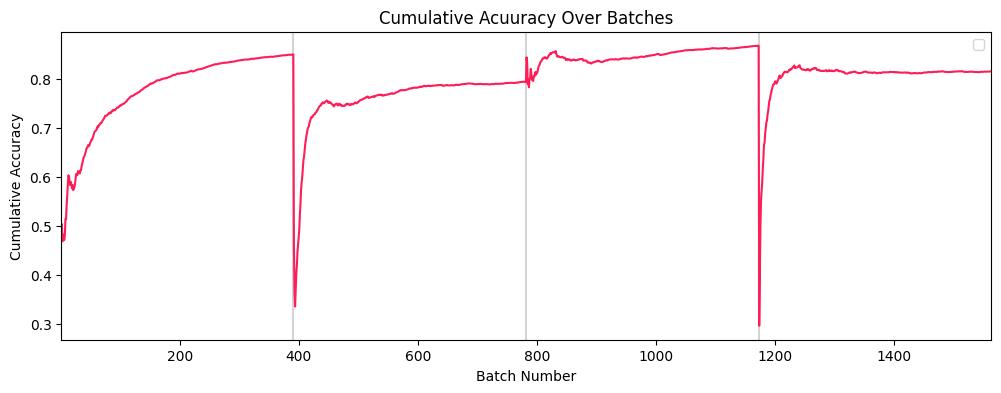

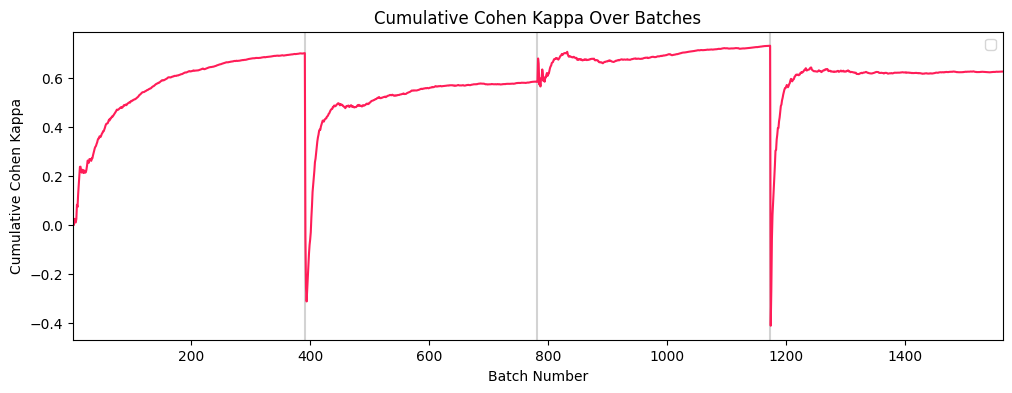

In [ ]:
batch_size = 128
hidden_size = 50
seq_len = 10
epoch_size=5
lr = 0.01
number_of_tasks=4
mask_selection_NofBatch = 50
mask_init='uniform'
base_model='lstm'
dataset = "sine_rw10_mode5_extended_16-16_1432"
df = pd.read_csv(os.path.join("datasets/datasets", f"{dataset}.csv"))
pretrain_model_addr='performance/pretrain/pretrain_mode_lstm_sine_rw10_mode5_extended_6-6_1234_1.pickle'
mask_weights=[]

model=cPB(model_class=PiggyBackGRU, lr = lr ,base_model=base_model, seq_len=seq_len, pretrain_model_addr=pretrain_model_addr,
           mask_weights=mask_weights, mask_init=mask_init, number_of_tasks=number_of_tasks,epoch_size=epoch_size)
iteration=1
# first loop for the iterations, for now it is just 1 iteration.
for iter in range(0,iteration):
  # loop for each task
  for task in range(1, df["task"].max() + 1):
    df_task = df[df["task"] == task]
    df_task = df_task.drop(columns="task")
    # loop based on each batch of data
    batch_cont=0
    model.weights_copy(task)
    for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if batch_cont<mask_selection_NofBatch:
        for mask_index in range (0, task):

          model.predict_many(x,y,mask_index)
          model.learn_many(x,y,mask_index)
        batch_cont+=1
      elif batch_cont==mask_selection_NofBatch:
        best_mask_index=model.add_new_column()
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
        batch_cont+=1
      elif batch_cont>mask_selection_NofBatch:
        batch_cont+=1
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
    model.save_final_metrics(task,best_mask_index)
    model.final_weights_saving()
  model.plotting()


In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score
import warnings

from models.cpnn_columns import cPNNColumns
from models.utils import (
    customized_loss,
    accuracy,
    cohen_kappa,
    kappa_temporal,
    get_samples_outputs,
    get_pred_from_outputs, kappa_temporal_score,
)
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
import copy
#from models.PiggyBackGRU import(
#	PiggyBackGRU,
#)

#from models.network import ModifiedGRU

import matplotlib.pyplot as plt
class cPB:
    """
    Class that implements all the cPNN structure.
    """

    def __init__(
        self,
        # this parameter is useless and i should remove it
        model_class=PiggyBackGRU,
        device=None,
        stride: int = 1,
        lr: float = 0.01,
        seq_len: int = 5,
        base_model='gru',
        pretrain_model_addr='',
        mask_weights=[],
        mask_init='1s',
        number_of_tasks=4,
        epoch_size=5,
        **kwargs,
    ):

      self.loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
      self.stride=stride
      self.seq_len=seq_len
      self.lr=lr
      self.base_model=base_model
      self.pretrain_model_addr=pretrain_model_addr
      self.mask_init=mask_init
      self.weights_list=[]
      self.selected_mask_index=[]
      self.epoch_size=epoch_size
      self.all_batch_acc=[[] for _ in range(number_of_tasks)]
      self.all_batch_kappa=[[] for _ in range(number_of_tasks)]
      self.acc_saving = [[]]
      self.cohen_kappa_saving=[[]]

      if model_class==PiggyBackGRU and pretrain_model_addr!='':
        self.model = ModifiedRNN(pretrain_model_addr=pretrain_model_addr,base_model=base_model,seq_len=seq_len,mask_weights=mask_weights,mask_init=mask_init)
        self.initial_weights = self.model.state_dict()

      self.final_weights=[]

    def get_seq_len(self):
        return self.seq_len

    def _cut_in_sequences(self, x, y):
        seqs_features = []
        seqs_targets = []
        for i in range(0, len(x), self.stride):
            if len(x) - i >= self.seq_len:
                seqs_features.append(x[i : i + self.seq_len, :].astype(np.float32))
                if y is not None:
                    seqs_targets.append(
                        np.asarray(y[i : i + self.seq_len], dtype=np.int_)
                    )
        return np.asarray(seqs_features), np.asarray(seqs_targets)

    def _cut_in_sequences_tensors(self, x, y):
        seqs_features = []
        seqs_targets = []
        for i in range(0, x.size()[0], self.stride):
            if x.size()[0] - i >= self.seq_len:
                seqs_features.append(
                    x[i : i + self.seq_len, :].view(1, self.seq_len, x.size()[1])
                )
                seqs_targets.append(y[i : i + self.seq_len].view(1, self.seq_len))
        seq_features = torch.cat(seqs_features, dim=0)
        seqs_targets = torch.cat(seqs_targets, dim=0)
        return seq_features, seqs_targets

    def _convert_to_tensor_dataset(self, x, y=None):

        x, y = self._cut_in_sequences(x, y)
        x = torch.tensor(x)
        if len(y) > 0:
            y = torch.tensor(y).type(torch.LongTensor)
            return data_utils.TensorDataset(x, y)
        return x

    def _load_batch(self, x: np.array, y: np.array = None):

        batch = self._convert_to_tensor_dataset(x, y)
        batch_loader = DataLoader(
            batch, batch_size=batch.tensors[0].size()[0], drop_last=False
        )
        y_seq = None
        for x, y_seq in batch_loader:  # only to take x and y from loader
            break
        y = torch.tensor(y)
        return x, y, y_seq


    def learn_many(self,x,y,task_number):

      self.model=self.rebuild_model(task_number)

      x = np.array(x)
      y = list(y)

      optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
      x, y, _ = self._load_batch(x, y)
      #print('inside the train and fit', x.shape)
      for i in range(0,self.epoch_size):
        y_pred = self.model(x)
        y_pred = get_samples_outputs(y_pred)
        pred, _ = get_pred_from_outputs(y_pred)
        loss = self.loss_fn(y_pred, y)
        # backward pass
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        # update weights
        optimizer.step()
      self.update_weights(task_number)

    def mask_return(self):
      return self.model.state_dict()
    def update_weights(self,task_number):
      self.weights_list[task_number]=copy.deepcopy(self.model.state_dict())

    def rebuild_model(self,task_number):
      param_list=[]
      for params in self.weights_list[task_number]:
        param_list.append(params)

      mask_weights=[]
      mask_weights.append(self.weights_list[task_number][param_list[-5]])
      mask_weights.append(self.weights_list[task_number][param_list[-4]])
      mask_weights.append(self.weights_list[task_number][param_list[-3]])
      mask_weights.append(self.weights_list[task_number][param_list[-2]])
      mask_weights.append(self.weights_list[task_number][param_list[-1]])
      self.model=ModifiedRNN(pretrain_model_addr=self.pretrain_model_addr,
                             base_model=self.base_model,seq_len=self.seq_len,mask_weights=mask_weights,
                             mask_init=self.mask_init)
      return self.model

    def final_weights_saving(self):
      self.final_weights.append(copy.deepcopy(self.model.state_dict()))

    def predict_many(self,x,y,task_number):
      x = np.array(x)
      y = list(y)
      x, y, _ = self._load_batch(x, y)
      #print('input shape', x.shape)
      y_pred = self.model(x)
      y_pred = get_samples_outputs(y_pred)
      pred, _ = get_pred_from_outputs(y_pred)
      kappa=cohen_kappa(y,pred).item()
      acc=accuracy_score(np.array(y),np.array(pred))
      self.acc_saving[task_number].append(acc)
      self.cohen_kappa_saving[task_number].append(kappa)
      #return acc, kappa

    def initial_weights_returning(self):
      return self.initial_weights

    def weights_copy(self, task_number):
      weights_list=[]
      for i in range(0,task_number-1):
        self.weights_list.append(copy.deepcopy(self.final_weights[i]))
      self.weights_list.append(copy.deepcopy(self.initial_weights))

    def add_new_column(self):
      avg_acc= np.mean(self.acc_saving, axis=1)
      avg_cohen_kappa = np.mean(self.cohen_kappa_saving, axis=1)
      index_of_best_acc = np.argmax(avg_acc)
      self.selected_mask_index.append(index_of_best_acc)
      print('list of accuracies that used for evaluating and selecting the models = ',avg_acc)
      print('list of kappa values that used for evaluating and selecting the models = ',avg_cohen_kappa)
      print('index of selcted mask for this task',index_of_best_acc)
      return index_of_best_acc
    def save_final_metrics(self,task,best_mask_index):
      self.all_batch_acc[task-1]=copy.deepcopy(self.acc_saving[best_mask_index])
      self.all_batch_kappa[task-1]=copy.deepcopy(self.cohen_kappa_saving[best_mask_index])
      print('All batches Accuracy= ', np.mean(self.all_batch_acc[task-1]))
      print('All batches cohen kappa= ', np.mean(self.all_batch_kappa[task-1]))
      self.acc_saving = [[] for _ in range(task+1)]
      self.cohen_kappa_saving=[[] for _ in range(task+1)]

    def plotting(self):

      x0=np.cumsum(self.all_batch_acc[0]) / np.arange(1, len(self.all_batch_acc[0]) + 1)
      x1=np.cumsum(self.all_batch_acc[1]) / np.arange(1, len(self.all_batch_acc[1]) + 1)
      x2=np.cumsum(self.all_batch_acc[2]) / np.arange(1, len(self.all_batch_acc[2]) + 1)
      x3=np.cumsum(self.all_batch_acc[3]) / np.arange(1, len(self.all_batch_acc[3]) + 1)
      all_x=np.concatenate((x0,x1,x2,x3),axis=0)
      vertical_lines_x = [len(x0), len(x0)+len(x1), len(x0)+len(x1)+len(x2)]
      y = all_x
      x = list(range(1,len(all_x) + 1))
      fig, ax = plt.subplots(figsize=(12, 4))
      ax.margins(x=0.0)
      for i in vertical_lines_x:
          plt.axvline(x=i, color='#D3D3D3', linestyle='-')
      ax.plot(x, y, color='#ff1d58')
      plt.xlabel('Batch Number')
      plt.ylabel('Cumulative Accuracy')
      plt.title('Cumulative Acuuracy Over Batches')
      plt.legend()
      plt.show()

      x0=np.cumsum(self.all_batch_kappa[0]) / np.arange(1, len(self.all_batch_kappa[0]) + 1)
      x1=np.cumsum(self.all_batch_kappa[1]) / np.arange(1, len(self.all_batch_kappa[1]) + 1)
      x2=np.cumsum(self.all_batch_kappa[2]) / np.arange(1, len(self.all_batch_kappa[2]) + 1)
      x3=np.cumsum(self.all_batch_kappa[3]) / np.arange(1, len(self.all_batch_kappa[3]) + 1)
      all_x=np.concatenate((x0,x1,x2,x3),axis=0)
      y = all_x
      fig, ax = plt.subplots(figsize=(12, 4))
      ax.margins(x=0.0)
      for i in vertical_lines_x:
          plt.axvline(x=i, color='#D3D3D3', linestyle='-')
      ax.plot(x, y, color='#ff1d58')
      plt.xlabel('Batch Number')
      plt.ylabel('Cumulative Cohen Kappa')
      plt.title('Cumulative Cohen Kappa Over Batches')
      plt.legend()
      plt.show()

In [ ]:
rnn = LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

(tensor([[[ 0.5870, -0.7764, -0.9885,  1.2475, -0.1424,  0.8793,  0.0677,
           0.2142,  0.1517, -1.9442,  1.9957,  1.4098, -0.7609,  0.9662,
          -0.3170, -1.2182, -0.9627, -0.4253,  1.7737, -0.9601],
         [ 1.0885, -0.8590, -0.8356,  1.0352,  1.0242, -2.1429, -0.8653,
          -0.3920,  0.5790,  0.3727, -0.8665, -0.0990, -0.6892,  0.1245,
          -0.8298,  0.8637, -0.3795, -1.7489, -1.3113, -0.0076],
         [ 0.2968,  0.8481,  1.5725, -0.2053, -1.1960,  1.0083,  0.8638,
          -0.8148,  0.2471,  0.4260, -1.5106,  1.1839, -1.6404, -0.6029,
          -1.0774, -0.0943,  0.0320,  0.5632,  0.3675,  0.9289]],

        [[-0.2914, -0.0675,  0.2684,  1.6922,  0.7361, -0.9469, -0.3605,
          -1.5020,  0.2495,  1.1563,  0.3117, -3.0567, -1.4118,  0.4131,
           0.5847,  0.4091, -0.3579, -1.3010,  0.8257,  1.1750],
         [-1.1378, -0.7213,  1.3948,  0.2036, -0.3849,  0.7407,  0.3736,
          -0.1315, -0.1744,  1.8208,  1.0082, -2.5872,  1.5531,  0.5766,
       

In [ ]:
c0

tensor([[[-0.4379,  0.7583,  0.0104, -1.5253, -0.9423,  0.7249, -0.6082,
           0.8144, -0.1980,  0.8845, -0.2133,  0.0674,  1.6433,  0.2107,
          -0.0360, -0.2612,  1.4793,  1.8452, -0.9301,  2.1839],
         [ 1.2000,  0.7390, -0.6485, -0.3333,  1.2839, -0.6023,  0.1745,
           0.9816,  1.6538,  1.9028, -1.4227,  0.4305,  1.1880, -0.1885,
          -0.6334,  0.3879, -0.6054, -0.8612,  0.4396,  0.1548],
         [ 0.0996, -0.2717, -1.2229,  0.1110,  0.4698,  0.9561, -1.3866,
          -0.2560, -0.0702,  0.8758,  1.3630, -0.7685,  0.7334, -1.2232,
          -0.9125, -0.8660,  0.1024, -1.3812,  0.5117,  0.9344]],

        [[ 1.6042, -0.8529, -1.1127,  1.8756,  1.4687,  0.2704, -1.6041,
          -0.1008,  1.4426, -1.0753, -0.4791, -0.3482,  0.5575, -0.7477,
           0.7057, -0.4616, -0.0579, -0.8264,  0.2726,  0.9378],
         [ 1.1138, -1.2458, -0.0168,  0.9063, -0.5269,  0.0512, -0.2125,
           0.3789, -0.5522, -1.3866,  1.3687,  1.0599, -0.2979, -0.5768,
        

In [ ]:
import math
import warnings
import numbers
import weakref
from typing import List, Tuple, Optional, overload

import torch
from torch import Tensor
from torch.nn.modules import Module
from torch.nn import Parameter
from torch.nn.utils.rnn import PackedSequence
from torch.nn import init
from torch import _VF

__all__ = ['RNNBase', 'RNN', 'LSTM', 'GRU', 'RNNCellBase', 'RNNCell', 'LSTMCell', 'GRUCell']

_rnn_impls = {
    'RNN_TANH': _VF.rnn_tanh,
    'RNN_RELU': _VF.rnn_relu,
}


def _apply_permutation(tensor: Tensor, permutation: Tensor, dim: int = 1) -> Tensor:
    return tensor.index_select(dim, permutation)


def apply_permutation(tensor: Tensor, permutation: Tensor, dim: int = 1) -> Tensor:
    warnings.warn("apply_permutation is deprecated, please use tensor.index_select(dim, permutation) instead")
    return _apply_permutation(tensor, permutation, dim)



class RNNBase(Module):
    r"""Base class for RNN modules (RNN, LSTM, GRU).

    Implements aspects of RNNs shared by the RNN, LSTM, and GRU classes, such as module initialization
    and utility methods for parameter storage management.

    .. note::
        The forward method is not implemented by the RNNBase class.

    .. note::
        LSTM and GRU classes override some methods implemented by RNNBase.
    """
    __constants__ = ['mode', 'input_size', 'hidden_size', 'num_layers', 'bias',
                     'batch_first', 'dropout', 'bidirectional', 'proj_size']
    __jit_unused_properties__ = ['all_weights']

    mode: str
    input_size: int
    hidden_size: int
    num_layers: int
    bias: bool
    batch_first: bool
    dropout: float
    bidirectional: bool
    proj_size: int

    def __init__(self, mode: str, input_size: int, hidden_size: int,
                 num_layers: int = 1, bias: bool = True, batch_first: bool = False,
                 dropout: float = 0., bidirectional: bool = False, proj_size: int = 0,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.batch_first = batch_first
        self.dropout = float(dropout)
        self.bidirectional = bidirectional
        self.proj_size = proj_size
        self._flat_weight_refs: List[Optional[weakref.ReferenceType[Parameter]]] = []
        num_directions = 2 if bidirectional else 1

        if not isinstance(dropout, numbers.Number) or not 0 <= dropout <= 1 or \
                isinstance(dropout, bool):
            raise ValueError("dropout should be a number in range [0, 1] "
                             "representing the probability of an element being "
                             "zeroed")
        if dropout > 0 and num_layers == 1:
            warnings.warn("dropout option adds dropout after all but last "
                          "recurrent layer, so non-zero dropout expects "
                          f"num_layers greater than 1, but got dropout={dropout} and "
                          f"num_layers={num_layers}")

        if not isinstance(hidden_size, int):
            raise TypeError(f"hidden_size should be of type int, got: {type(hidden_size).__name__}")
        if hidden_size <= 0:
            raise ValueError("hidden_size must be greater than zero")
        if proj_size < 0:
            raise ValueError("proj_size should be a positive integer or zero to disable projections")
        if proj_size >= hidden_size:
            raise ValueError("proj_size has to be smaller than hidden_size")

        if mode == 'LSTM':
            gate_size = 4 * hidden_size
        elif mode == 'GRU':
            gate_size = 3 * hidden_size
        elif mode == 'RNN_TANH':
            gate_size = hidden_size
        elif mode == 'RNN_RELU':
            gate_size = hidden_size
        else:
            raise ValueError("Unrecognized RNN mode: " + mode)

        self._flat_weights_names = []
        self._all_weights = []
        for layer in range(num_layers):
            for direction in range(num_directions):
                real_hidden_size = proj_size if proj_size > 0 else hidden_size
                layer_input_size = input_size if layer == 0 else real_hidden_size * num_directions

                w_ih = Parameter(torch.empty((gate_size, layer_input_size), **factory_kwargs))
                w_hh = Parameter(torch.empty((gate_size, real_hidden_size), **factory_kwargs))
                b_ih = Parameter(torch.empty(gate_size, **factory_kwargs))
                # Second bias vector included for CuDNN compatibility. Only one
                # bias vector is needed in standard definition.
                b_hh = Parameter(torch.empty(gate_size, **factory_kwargs))
                layer_params: Tuple[Tensor, ...] = ()
                if self.proj_size == 0:
                    if bias:
                        layer_params = (w_ih, w_hh, b_ih, b_hh)
                    else:
                        layer_params = (w_ih, w_hh)
                else:
                    w_hr = Parameter(torch.empty((proj_size, hidden_size), **factory_kwargs))
                    if bias:
                        layer_params = (w_ih, w_hh, b_ih, b_hh, w_hr)
                    else:
                        layer_params = (w_ih, w_hh, w_hr)

                suffix = '_reverse' if direction == 1 else ''
                param_names = ['weight_ih_l{}{}', 'weight_hh_l{}{}']
                if bias:
                    param_names += ['bias_ih_l{}{}', 'bias_hh_l{}{}']
                if self.proj_size > 0:
                    param_names += ['weight_hr_l{}{}']
                param_names = [x.format(layer, suffix) for x in param_names]

                for name, param in zip(param_names, layer_params):
                    setattr(self, name, param)
                self._flat_weights_names.extend(param_names)
                self._all_weights.append(param_names)

        self._init_flat_weights()

        self.reset_parameters()

    def _init_flat_weights(self):
        self._flat_weights = [getattr(self, wn) if hasattr(self, wn) else None
                              for wn in self._flat_weights_names]
        self._flat_weight_refs = [weakref.ref(w) if w is not None else None
                                  for w in self._flat_weights]
        self.flatten_parameters()

    def __setattr__(self, attr, value):
        if hasattr(self, "_flat_weights_names") and attr in self._flat_weights_names:
            # keep self._flat_weights up to date if you do self.weight = ...
            idx = self._flat_weights_names.index(attr)
            self._flat_weights[idx] = value
        super().__setattr__(attr, value)


    def flatten_parameters(self) -> None:
        """Resets parameter data pointer so that they can use faster code paths.

        Right now, this works only if the module is on the GPU and cuDNN is enabled.
        Otherwise, it's a no-op.
        """
        # Short-circuits if _flat_weights is only partially instantiated
        if len(self._flat_weights) != len(self._flat_weights_names):
            return

        for w in self._flat_weights:
            if not isinstance(w, Tensor):
                return
        # Short-circuits if any tensor in self._flat_weights is not acceptable to cuDNN
        # or the tensors in _flat_weights are of different dtypes

        first_fw = self._flat_weights[0]
        dtype = first_fw.dtype
        for fw in self._flat_weights:
            if (not isinstance(fw.data, Tensor) or not (fw.data.dtype == dtype) or
                    not fw.data.is_cuda or
                    not torch.backends.cudnn.is_acceptable(fw.data)):
                return

        # If any parameters alias, we fall back to the slower, copying code path. This is
        # a sufficient check, because overlapping parameter buffers that don't completely
        # alias would break the assumptions of the uniqueness check in
        # Module.named_parameters().
        unique_data_ptrs = {p.data_ptr() for p in self._flat_weights}
        if len(unique_data_ptrs) != len(self._flat_weights):
            return

        with torch.cuda.device_of(first_fw):
            import torch.backends.cudnn.rnn as rnn

            # Note: no_grad() is necessary since _cudnn_rnn_flatten_weight is
            # an inplace operation on self._flat_weights
            with torch.no_grad():
                if torch._use_cudnn_rnn_flatten_weight():
                    num_weights = 4 if self.bias else 2
                    if self.proj_size > 0:
                        num_weights += 1
                    torch._cudnn_rnn_flatten_weight(
                        self._flat_weights, num_weights,
                        self.input_size, rnn.get_cudnn_mode(self.mode),
                        self.hidden_size, self.proj_size, self.num_layers,
                        self.batch_first, bool(self.bidirectional))


    def _apply(self, fn, recurse=True):
        ret = super()._apply(fn, recurse)

        # Resets _flat_weights
        # Note: be v. careful before removing this, as 3rd party device types
        # likely rely on this behavior to properly .to() modules like LSTM.
        self._init_flat_weights()

        return ret

    def reset_parameters(self) -> None:
        stdv = 1.0 / math.sqrt(self.hidden_size) if self.hidden_size > 0 else 0
        for weight in self.parameters():
            init.uniform_(weight, -stdv, stdv)

    def check_input(self, input: Tensor, batch_sizes: Optional[Tensor]) -> None:
        if not torch.jit.is_scripting():
            if input.dtype != self._flat_weights[0].dtype and not torch._C._is_any_autocast_enabled():
                raise ValueError(f'input must have the type {self._flat_weights[0].dtype}, got type {input.dtype}')
        expected_input_dim = 2 if batch_sizes is not None else 3
        if input.dim() != expected_input_dim:
            raise RuntimeError(
                f'input must have {expected_input_dim} dimensions, got {input.dim()}')
        if self.input_size != input.size(-1):
            raise RuntimeError(
                f'input.size(-1) must be equal to input_size. Expected {self.input_size}, got {input.size(-1)}')

    def get_expected_hidden_size(self, input: Tensor, batch_sizes: Optional[Tensor]) -> Tuple[int, int, int]:
        if batch_sizes is not None:
            mini_batch = int(batch_sizes[0])
        else:
            mini_batch = input.size(0) if self.batch_first else input.size(1)
        num_directions = 2 if self.bidirectional else 1
        if self.proj_size > 0:
            expected_hidden_size = (self.num_layers * num_directions,
                                    mini_batch, self.proj_size)
        else:
            expected_hidden_size = (self.num_layers * num_directions,
                                    mini_batch, self.hidden_size)
        return expected_hidden_size

    def check_hidden_size(self, hx: Tensor, expected_hidden_size: Tuple[int, int, int],
                          msg: str = 'Expected hidden size {}, got {}') -> None:
        if hx.size() != expected_hidden_size:
            raise RuntimeError(msg.format(expected_hidden_size, list(hx.size())))

    def _weights_have_changed(self):
        # Returns True if the weight tensors have changed since the last forward pass.
        # This is the case when used with torch.func.functional_call(), for example.
        weights_changed = False
        for ref, name in zip(self._flat_weight_refs, self._flat_weights_names):
            weight = getattr(self, name) if hasattr(self, name) else None
            if weight is not None and ref is not None and ref() is not weight:
                weights_changed = True
                break
        return weights_changed

    def check_forward_args(self, input: Tensor, hidden: Tensor, batch_sizes: Optional[Tensor]):
        self.check_input(input, batch_sizes)
        expected_hidden_size = self.get_expected_hidden_size(input, batch_sizes)

        self.check_hidden_size(hidden, expected_hidden_size)

    def permute_hidden(self, hx: Tensor, permutation: Optional[Tensor]):
        if permutation is None:
            return hx
        return _apply_permutation(hx, permutation)


    def extra_repr(self) -> str:
        s = '{input_size}, {hidden_size}'
        if self.proj_size != 0:
            s += ', proj_size={proj_size}'
        if self.num_layers != 1:
            s += ', num_layers={num_layers}'
        if self.bias is not True:
            s += ', bias={bias}'
        if self.batch_first is not False:
            s += ', batch_first={batch_first}'
        if self.dropout != 0:
            s += ', dropout={dropout}'
        if self.bidirectional is not False:
            s += ', bidirectional={bidirectional}'
        return s.format(**self.__dict__)

    def _update_flat_weights(self):
        if not torch.jit.is_scripting():
            if self._weights_have_changed():
                self._init_flat_weights()

    def __getstate__(self):
        # If weights have been changed, update the _flat_weights in __getstate__ here.
        self._update_flat_weights()
        # Don't serialize the weight references.
        state = self.__dict__.copy()
        del state['_flat_weight_refs']
        return state

    def __setstate__(self, d):
        super().__setstate__(d)
        if 'all_weights' in d:
            self._all_weights = d['all_weights']
        # In PyTorch 1.8 we added a proj_size member variable to LSTM.
        # LSTMs that were serialized via torch.save(module) before PyTorch 1.8
        # don't have it, so to preserve compatibility we set proj_size here.
        if 'proj_size' not in d:
            self.proj_size = 0

        if not isinstance(self._all_weights[0][0], str):
            num_layers = self.num_layers
            num_directions = 2 if self.bidirectional else 1
            self._flat_weights_names = []
            self._all_weights = []
            for layer in range(num_layers):
                for direction in range(num_directions):
                    suffix = '_reverse' if direction == 1 else ''
                    weights = ['weight_ih_l{}{}', 'weight_hh_l{}{}', 'bias_ih_l{}{}',
                               'bias_hh_l{}{}', 'weight_hr_l{}{}']
                    weights = [x.format(layer, suffix) for x in weights]
                    if self.bias:
                        if self.proj_size > 0:
                            self._all_weights += [weights]
                            self._flat_weights_names.extend(weights)
                        else:
                            self._all_weights += [weights[:4]]
                            self._flat_weights_names.extend(weights[:4])
                    else:
                        if self.proj_size > 0:
                            self._all_weights += [weights[:2]] + [weights[-1:]]
                            self._flat_weights_names.extend(weights[:2] + [weights[-1:]])
                        else:
                            self._all_weights += [weights[:2]]
                            self._flat_weights_names.extend(weights[:2])
            self._flat_weights = [getattr(self, wn) if hasattr(self, wn) else None
                                  for wn in self._flat_weights_names]

        self._flat_weight_refs = [weakref.ref(w) if w is not None else None
                                  for w in self._flat_weights]

    @property
    def all_weights(self) -> List[List[Parameter]]:
        return [[getattr(self, weight) for weight in weights] for weights in self._all_weights]

    def _replicate_for_data_parallel(self):
        replica = super()._replicate_for_data_parallel()
        # Need to copy these caches, otherwise the replica will share the same
        # flat weights list.
        replica._flat_weights = replica._flat_weights[:]
        replica._flat_weights_names = replica._flat_weights_names[:]
        return replica




class RNN(RNNBase):
    r"""__init__(self,input_size,hidden_size,num_layers=1,nonlinearity='tanh',bias=True,batch_first=False,dropout=0.0,bidirectional=False,device=None,dtype=None)

    Applies a multi-layer Elman RNN with :math:`\tanh` or :math:`\text{ReLU}` non-linearity to an
    input sequence.

    For each element in the input sequence, each layer computes the following
    function:

    .. math::
        h_t = \tanh(x_t W_{ih}^T + b_{ih} + h_{t-1}W_{hh}^T + b_{hh})

    where :math:`h_t` is the hidden state at time `t`, :math:`x_t` is
    the input at time `t`, and :math:`h_{(t-1)}` is the hidden state of the
    previous layer at time `t-1` or the initial hidden state at time `0`.
    If :attr:`nonlinearity` is ``'relu'``, then :math:`\text{ReLU}` is used instead of :math:`\tanh`.

    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
            would mean stacking two RNNs together to form a `stacked RNN`,
            with the second RNN taking in outputs of the first RNN and
            computing the final results. Default: 1
        nonlinearity: The non-linearity to use. Can be either ``'tanh'`` or ``'relu'``. Default: ``'tanh'``
        bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
            Default: ``True``
        batch_first: If ``True``, then the input and output tensors are provided
            as `(batch, seq, feature)` instead of `(seq, batch, feature)`.
            Note that this does not apply to hidden or cell states. See the
            Inputs/Outputs sections below for details.  Default: ``False``
        dropout: If non-zero, introduces a `Dropout` layer on the outputs of each
            RNN layer except the last layer, with dropout probability equal to
            :attr:`dropout`. Default: 0
        bidirectional: If ``True``, becomes a bidirectional RNN. Default: ``False``

    Inputs: input, h_0
        * **input**: tensor of shape :math:`(L, H_{in})` for unbatched input,
          :math:`(L, N, H_{in})` when ``batch_first=False`` or
          :math:`(N, L, H_{in})` when ``batch_first=True`` containing the features of
          the input sequence.  The input can also be a packed variable length sequence.
          See :func:`torch.nn.utils.rnn.pack_padded_sequence` or
          :func:`torch.nn.utils.rnn.pack_sequence` for details.
        * **h_0**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` for unbatched input or
          :math:`(D * \text{num\_layers}, N, H_{out})` containing the initial hidden
          state for the input sequence batch. Defaults to zeros if not provided.

        where:

        .. math::
            \begin{aligned}
                N ={} & \text{batch size} \\
                L ={} & \text{sequence length} \\
                D ={} & 2 \text{ if bidirectional=True otherwise } 1 \\
                H_{in} ={} & \text{input\_size} \\
                H_{out} ={} & \text{hidden\_size}
            \end{aligned}

    Outputs: output, h_n
        * **output**: tensor of shape :math:`(L, D * H_{out})` for unbatched input,
          :math:`(L, N, D * H_{out})` when ``batch_first=False`` or
          :math:`(N, L, D * H_{out})` when ``batch_first=True`` containing the output features
          `(h_t)` from the last layer of the RNN, for each `t`. If a
          :class:`torch.nn.utils.rnn.PackedSequence` has been given as the input, the output
          will also be a packed sequence.
        * **h_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` for unbatched input or
          :math:`(D * \text{num\_layers}, N, H_{out})` containing the final hidden state
          for each element in the batch.

    Attributes:
        weight_ih_l[k]: the learnable input-hidden weights of the k-th layer,
            of shape `(hidden_size, input_size)` for `k = 0`. Otherwise, the shape is
            `(hidden_size, num_directions * hidden_size)`
        weight_hh_l[k]: the learnable hidden-hidden weights of the k-th layer,
            of shape `(hidden_size, hidden_size)`
        bias_ih_l[k]: the learnable input-hidden bias of the k-th layer,
            of shape `(hidden_size)`
        bias_hh_l[k]: the learnable hidden-hidden bias of the k-th layer,
            of shape `(hidden_size)`

    .. note::
        All the weights and biases are initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`
        where :math:`k = \frac{1}{\text{hidden\_size}}`

    .. note::
        For bidirectional RNNs, forward and backward are directions 0 and 1 respectively.
        Example of splitting the output layers when ``batch_first=False``:
        ``output.view(seq_len, batch, num_directions, hidden_size)``.

    .. note::
        ``batch_first`` argument is ignored for unbatched inputs.

    .. include:: ../cudnn_rnn_determinism.rst

    .. include:: ../cudnn_persistent_rnn.rst

    Examples::

        >>> rnn = nn.RNN(10, 20, 2)
        >>> input = torch.randn(5, 3, 10)
        >>> h0 = torch.randn(2, 3, 20)
        >>> output, hn = rnn(input, h0)
    """

    @overload
    def __init__(self, input_size: int, hidden_size: int, num_layers: int = 1,
                 nonlinearity: str = 'tanh', bias: bool = True, batch_first: bool = False,
                 dropout: float = 0., bidirectional: bool = False, device=None,
                 dtype=None) -> None:
        ...

    @overload
    def __init__(self, *args, **kwargs):
        ...

    def __init__(self, *args, **kwargs):
        if 'proj_size' in kwargs:
            raise ValueError("proj_size argument is only supported for LSTM, not RNN or GRU")
        self.nonlinearity = kwargs.pop('nonlinearity', 'tanh')
        if self.nonlinearity == 'tanh':
            mode = 'RNN_TANH'
        elif self.nonlinearity == 'relu':
            mode = 'RNN_RELU'
        else:
            raise ValueError(f"Unknown nonlinearity '{self.nonlinearity}'. Select from 'tanh' or 'relu'.")
        super().__init__(mode, *args, **kwargs)

    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(self, input: Tensor, hx: Optional[Tensor] = None) -> Tuple[Tensor, Tensor]:
        pass

    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(self, input: PackedSequence, hx: Optional[Tensor] = None) -> Tuple[PackedSequence, Tensor]:
        pass

    def forward(self, input, hx=None):  # noqa: F811
        self._update_flat_weights()

        num_directions = 2 if self.bidirectional else 1
        orig_input = input

        if isinstance(orig_input, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = batch_sizes[0]
            # script() is unhappy when max_batch_size is different type in cond branches, so we duplicate
            if hx is None:
                hx = torch.zeros(self.num_layers * num_directions,
                                 max_batch_size, self.hidden_size,
                                 dtype=input.dtype, device=input.device)
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)
        else:
            batch_sizes = None
            if input.dim() not in (2, 3):
                raise ValueError(f"RNN: Expected input to be 2D or 3D, got {input.dim()}D tensor instead")
            is_batched = input.dim() == 3
            batch_dim = 0 if self.batch_first else 1
            if not is_batched:
                input = input.unsqueeze(batch_dim)
                if hx is not None:
                    if hx.dim() != 2:
                        raise RuntimeError(
                            f"For unbatched 2-D input, hx should also be 2-D but got {hx.dim()}-D tensor")
                    hx = hx.unsqueeze(1)
            else:
                if hx is not None and hx.dim() != 3:
                    raise RuntimeError(
                        f"For batched 3-D input, hx should also be 3-D but got {hx.dim()}-D tensor")
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None
            if hx is None:
                hx = torch.zeros(self.num_layers * num_directions,
                                 max_batch_size, self.hidden_size,
                                 dtype=input.dtype, device=input.device)
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)

        assert hx is not None
        self.check_forward_args(input, hx, batch_sizes)
        assert self.mode == 'RNN_TANH' or self.mode == 'RNN_RELU'
        if batch_sizes is None:
            if self.mode == 'RNN_TANH':
                result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,
                                      self.dropout, self.training, self.bidirectional,
                                      self.batch_first)
            else:
                result = _VF.rnn_relu(input, hx, self._flat_weights, self.bias, self.num_layers,
                                      self.dropout, self.training, self.bidirectional,
                                      self.batch_first)
        else:
            if self.mode == 'RNN_TANH':
                result = _VF.rnn_tanh(input, batch_sizes, hx, self._flat_weights, self.bias,
                                      self.num_layers, self.dropout, self.training,
                                      self.bidirectional)
            else:
                result = _VF.rnn_relu(input, batch_sizes, hx, self._flat_weights, self.bias,
                                      self.num_layers, self.dropout, self.training,
                                      self.bidirectional)

        output = result[0]
        hidden = result[1]

        if isinstance(orig_input, PackedSequence):
            output_packed = PackedSequence(output, batch_sizes, sorted_indices, unsorted_indices)
            return output_packed, self.permute_hidden(hidden, unsorted_indices)

        if not is_batched:
            output = output.squeeze(batch_dim)
            hidden = hidden.squeeze(1)

        return output, self.permute_hidden(hidden, unsorted_indices)


# XXX: LSTM and GRU implementation is different from RNNBase, this is because:
# 1. we want to support nn.LSTM and nn.GRU in TorchScript and TorchScript in
#    its current state could not support the python Union Type or Any Type
# 2. TorchScript static typing does not allow a Function or Callable type in
#    Dict values, so we have to separately call _VF instead of using _rnn_impls
# 3. This is temporary only and in the transition state that we want to make it
#    on time for the release
#
# More discussion details in https://github.com/pytorch/pytorch/pull/23266
#
# TODO: remove the overriding implementations for LSTM and GRU when TorchScript
# support expressing these two modules generally.



class LSTM(RNNBase):
    r"""__init__(self,input_size,hidden_size,num_layers=1,bias=True,batch_first=False,dropout=0.0,bidirectional=False,proj_size=0,device=None,dtype=None)

    Applies a multi-layer long short-term memory (LSTM) RNN to an input
    sequence.

    For each element in the input sequence, each layer computes the following
    function:

    .. math::
        \begin{array}{ll} \\
            i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
            f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
            g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
            o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
            c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
            h_t = o_t \odot \tanh(c_t) \\
        \end{array}

    where :math:`h_t` is the hidden state at time `t`, :math:`c_t` is the cell
    state at time `t`, :math:`x_t` is the input at time `t`, :math:`h_{t-1}`
    is the hidden state of the layer at time `t-1` or the initial hidden
    state at time `0`, and :math:`i_t`, :math:`f_t`, :math:`g_t`,
    :math:`o_t` are the input, forget, cell, and output gates, respectively.
    :math:`\sigma` is the sigmoid function, and :math:`\odot` is the Hadamard product.

    In a multilayer LSTM, the input :math:`x^{(l)}_t` of the :math:`l` -th layer
    (:math:`l \ge 2`) is the hidden state :math:`h^{(l-1)}_t` of the previous layer multiplied by
    dropout :math:`\delta^{(l-1)}_t` where each :math:`\delta^{(l-1)}_t` is a Bernoulli random
    variable which is :math:`0` with probability :attr:`dropout`.

    If ``proj_size > 0`` is specified, LSTM with projections will be used. This changes
    the LSTM cell in the following way. First, the dimension of :math:`h_t` will be changed from
    ``hidden_size`` to ``proj_size`` (dimensions of :math:`W_{hi}` will be changed accordingly).
    Second, the output hidden state of each layer will be multiplied by a learnable projection
    matrix: :math:`h_t = W_{hr}h_t`. Note that as a consequence of this, the output
    of LSTM network will be of different shape as well. See Inputs/Outputs sections below for exact
    dimensions of all variables. You can find more details in https://arxiv.org/abs/1402.1128.

    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
            would mean stacking two LSTMs together to form a `stacked LSTM`,
            with the second LSTM taking in outputs of the first LSTM and
            computing the final results. Default: 1
        bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
            Default: ``True``
        batch_first: If ``True``, then the input and output tensors are provided
            as `(batch, seq, feature)` instead of `(seq, batch, feature)`.
            Note that this does not apply to hidden or cell states. See the
            Inputs/Outputs sections below for details.  Default: ``False``
        dropout: If non-zero, introduces a `Dropout` layer on the outputs of each
            LSTM layer except the last layer, with dropout probability equal to
            :attr:`dropout`. Default: 0
        bidirectional: If ``True``, becomes a bidirectional LSTM. Default: ``False``
        proj_size: If ``> 0``, will use LSTM with projections of corresponding size. Default: 0

    Inputs: input, (h_0, c_0)
        * **input**: tensor of shape :math:`(L, H_{in})` for unbatched input,
          :math:`(L, N, H_{in})` when ``batch_first=False`` or
          :math:`(N, L, H_{in})` when ``batch_first=True`` containing the features of
          the input sequence.  The input can also be a packed variable length sequence.
          See :func:`torch.nn.utils.rnn.pack_padded_sequence` or
          :func:`torch.nn.utils.rnn.pack_sequence` for details.
        * **h_0**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` for unbatched input or
          :math:`(D * \text{num\_layers}, N, H_{out})` containing the
          initial hidden state for each element in the input sequence.
          Defaults to zeros if (h_0, c_0) is not provided.
        * **c_0**: tensor of shape :math:`(D * \text{num\_layers}, H_{cell})` for unbatched input or
          :math:`(D * \text{num\_layers}, N, H_{cell})` containing the
          initial cell state for each element in the input sequence.
          Defaults to zeros if (h_0, c_0) is not provided.

        where:

        .. math::
            \begin{aligned}
                N ={} & \text{batch size} \\
                L ={} & \text{sequence length} \\
                D ={} & 2 \text{ if bidirectional=True otherwise } 1 \\
                H_{in} ={} & \text{input\_size} \\
                H_{cell} ={} & \text{hidden\_size} \\
                H_{out} ={} & \text{proj\_size if } \text{proj\_size}>0 \text{ otherwise hidden\_size} \\
            \end{aligned}

    Outputs: output, (h_n, c_n)
        * **output**: tensor of shape :math:`(L, D * H_{out})` for unbatched input,
          :math:`(L, N, D * H_{out})` when ``batch_first=False`` or
          :math:`(N, L, D * H_{out})` when ``batch_first=True`` containing the output features
          `(h_t)` from the last layer of the LSTM, for each `t`. If a
          :class:`torch.nn.utils.rnn.PackedSequence` has been given as the input, the output
          will also be a packed sequence. When ``bidirectional=True``, `output` will contain
          a concatenation of the forward and reverse hidden states at each time step in the sequence.
        * **h_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` for unbatched input or
          :math:`(D * \text{num\_layers}, N, H_{out})` containing the
          final hidden state for each element in the sequence. When ``bidirectional=True``,
          `h_n` will contain a concatenation of the final forward and reverse hidden states, respectively.
        * **c_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{cell})` for unbatched input or
          :math:`(D * \text{num\_layers}, N, H_{cell})` containing the
          final cell state for each element in the sequence. When ``bidirectional=True``,
          `c_n` will contain a concatenation of the final forward and reverse cell states, respectively.

    Attributes:
        weight_ih_l[k] : the learnable input-hidden weights of the :math:`\text{k}^{th}` layer
            `(W_ii|W_if|W_ig|W_io)`, of shape `(4*hidden_size, input_size)` for `k = 0`.
            Otherwise, the shape is `(4*hidden_size, num_directions * hidden_size)`. If
            ``proj_size > 0`` was specified, the shape will be
            `(4*hidden_size, num_directions * proj_size)` for `k > 0`
        weight_hh_l[k] : the learnable hidden-hidden weights of the :math:`\text{k}^{th}` layer
            `(W_hi|W_hf|W_hg|W_ho)`, of shape `(4*hidden_size, hidden_size)`. If ``proj_size > 0``
            was specified, the shape will be `(4*hidden_size, proj_size)`.
        bias_ih_l[k] : the learnable input-hidden bias of the :math:`\text{k}^{th}` layer
            `(b_ii|b_if|b_ig|b_io)`, of shape `(4*hidden_size)`
        bias_hh_l[k] : the learnable hidden-hidden bias of the :math:`\text{k}^{th}` layer
            `(b_hi|b_hf|b_hg|b_ho)`, of shape `(4*hidden_size)`
        weight_hr_l[k] : the learnable projection weights of the :math:`\text{k}^{th}` layer
            of shape `(proj_size, hidden_size)`. Only present when ``proj_size > 0`` was
            specified.
        weight_ih_l[k]_reverse: Analogous to `weight_ih_l[k]` for the reverse direction.
            Only present when ``bidirectional=True``.
        weight_hh_l[k]_reverse:  Analogous to `weight_hh_l[k]` for the reverse direction.
            Only present when ``bidirectional=True``.
        bias_ih_l[k]_reverse:  Analogous to `bias_ih_l[k]` for the reverse direction.
            Only present when ``bidirectional=True``.
        bias_hh_l[k]_reverse:  Analogous to `bias_hh_l[k]` for the reverse direction.
            Only present when ``bidirectional=True``.
        weight_hr_l[k]_reverse:  Analogous to `weight_hr_l[k]` for the reverse direction.
            Only present when ``bidirectional=True`` and ``proj_size > 0`` was specified.

    .. note::
        All the weights and biases are initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`
        where :math:`k = \frac{1}{\text{hidden\_size}}`

    .. note::
        For bidirectional LSTMs, forward and backward are directions 0 and 1 respectively.
        Example of splitting the output layers when ``batch_first=False``:
        ``output.view(seq_len, batch, num_directions, hidden_size)``.

    .. note::
        For bidirectional LSTMs, `h_n` is not equivalent to the last element of `output`; the
        former contains the final forward and reverse hidden states, while the latter contains the
        final forward hidden state and the initial reverse hidden state.

    .. note::
        ``batch_first`` argument is ignored for unbatched inputs.

    .. note::
        ``proj_size`` should be smaller than ``hidden_size``.

    .. include:: ../cudnn_rnn_determinism.rst

    .. include:: ../cudnn_persistent_rnn.rst

    Examples::

        >>> rnn = nn.LSTM(10, 20, 2)
        >>> input = torch.randn(5, 3, 10)
        >>> h0 = torch.randn(2, 3, 20)
        >>> c0 = torch.randn(2, 3, 20)
        >>> output, (hn, cn) = rnn(input, (h0, c0))
    """

    @overload
    def __init__(self, input_size: int, hidden_size: int, num_layers: int = 1, bias: bool = True,
                 batch_first: bool = False, dropout: float = 0., bidirectional: bool = False,
                 proj_size: int = 0, device=None, dtype=None) -> None:
        ...

    @overload
    def __init__(self, *args, **kwargs):
        ...

    def __init__(self, *args, **kwargs):
        super().__init__('LSTM', *args, **kwargs)

    def get_expected_cell_size(self, input: Tensor, batch_sizes: Optional[Tensor]) -> Tuple[int, int, int]:
        if batch_sizes is not None:
            mini_batch = int(batch_sizes[0])
        else:
            mini_batch = input.size(0) if self.batch_first else input.size(1)
        num_directions = 2 if self.bidirectional else 1
        expected_hidden_size = (self.num_layers * num_directions,
                                mini_batch, self.hidden_size)
        return expected_hidden_size

    # In the future, we should prevent mypy from applying contravariance rules here.
    # See torch/nn/modules/module.py::_forward_unimplemented
    def check_forward_args(self,  # type: ignore[override]
                           input: Tensor,
                           hidden: Tuple[Tensor, Tensor],
                           batch_sizes: Optional[Tensor],
                           ):
        self.check_input(input, batch_sizes)
        self.check_hidden_size(hidden[0], self.get_expected_hidden_size(input, batch_sizes),
                               'Expected hidden[0] size {}, got {}')
        self.check_hidden_size(hidden[1], self.get_expected_cell_size(input, batch_sizes),
                               'Expected hidden[1] size {}, got {}')

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    def permute_hidden(self,  # type: ignore[override]
                       hx: Tuple[Tensor, Tensor],
                       permutation: Optional[Tensor]
                       ) -> Tuple[Tensor, Tensor]:
        if permutation is None:
            return hx
        return _apply_permutation(hx[0], permutation), _apply_permutation(hx[1], permutation)

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    @overload  # type: ignore[override]
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(self, input: Tensor, hx: Optional[Tuple[Tensor, Tensor]] = None
                ) -> Tuple[Tensor, Tuple[Tensor, Tensor]]:  # noqa: F811
        pass

    # Same as above, see torch/nn/modules/module.py::_forward_unimplemented
    @overload
    @torch._jit_internal._overload_method  # noqa: F811
    def forward(self, input: PackedSequence, hx: Optional[Tuple[Tensor, Tensor]] = None
                ) -> Tuple[PackedSequence, Tuple[Tensor, Tensor]]:  # noqa: F811
        pass

    def forward(self, input, hx=None):  # noqa: F811
        self._update_flat_weights()

        orig_input = input
        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        batch_sizes = None
        do_permute = False
        num_directions = 2 if self.bidirectional else 1
        real_hidden_size = self.proj_size if self.proj_size > 0 else self.hidden_size
        if isinstance(orig_input, PackedSequence):
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = batch_sizes[0]
            if hx is None:
                h_zeros = torch.zeros(self.num_layers * num_directions,
                                      max_batch_size, real_hidden_size,
                                      dtype=input.dtype, device=input.device)
                c_zeros = torch.zeros(self.num_layers * num_directions,
                                      max_batch_size, self.hidden_size,
                                      dtype=input.dtype, device=input.device)
                hx = (h_zeros, c_zeros)
            else:
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                hx = self.permute_hidden(hx, sorted_indices)
        else:
            if input.dim() not in (2, 3):
                raise ValueError(f"LSTM: Expected input to be 2D or 3D, got {input.dim()}D instead")
            is_batched = input.dim() == 3
            batch_dim = 0 if self.batch_first else 1
            if not is_batched:
                input = input.unsqueeze(batch_dim)
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None
            if hx is None:
                h_zeros = torch.zeros(self.num_layers * num_directions,
                                      max_batch_size, real_hidden_size,
                                      dtype=input.dtype, device=input.device)
                c_zeros = torch.zeros(self.num_layers * num_directions,
                                      max_batch_size, self.hidden_size,
                                      dtype=input.dtype, device=input.device)
                hx = (h_zeros, c_zeros)
            else:
                if is_batched:
                    if (hx[0].dim() != 3 or hx[1].dim() != 3):
                        msg = ("For batched 3-D input, hx and cx should "
                               f"also be 3-D but got ({hx[0].dim()}-D, {hx[1].dim()}-D) tensors")
                        raise RuntimeError(msg)
                else:
                    if hx[0].dim() != 2 or hx[1].dim() != 2:
                        msg = ("For unbatched 2-D input, hx and cx should "
                               f"also be 2-D but got ({hx[0].dim()}-D, {hx[1].dim()}-D) tensors")
                        raise RuntimeError(msg)
                    hx = (hx[0].unsqueeze(1), hx[1].unsqueeze(1))
                # Each batch of the hidden state should match the input sequence that
                # the user believes he/she is passing in.
                self.check_forward_args(input, hx, batch_sizes)
                hx = self.permute_hidden(hx, sorted_indices)

        if batch_sizes is None:
            #print(hx.shape)
            print(hx)
            result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
                              self.dropout, self.training, self.bidirectional, self.batch_first)
        else:
            result = _VF.lstm(input, batch_sizes, hx, self._flat_weights, self.bias,
                              self.num_layers, self.dropout, self.training, self.bidirectional)
        output = result[0]
        hidden = result[1:]
        # xxx: isinstance check needs to be in conditional for TorchScript to compile
        if isinstance(orig_input, PackedSequence):
            output_packed = PackedSequence(output, batch_sizes, sorted_indices, unsorted_indices)
            return output_packed, self.permute_hidden(hidden, unsorted_indices)
        else:
            if not is_batched:
                output = output.squeeze(batch_dim)
                hidden = (hidden[0].squeeze(1), hidden[1].squeeze(1))
            return output, self.permute_hidden(hidden, unsorted_indices)




class RNNCellBase(Module):
    __constants__ = ['input_size', 'hidden_size', 'bias']

    input_size: int
    hidden_size: int
    bias: bool
    weight_ih: Tensor
    weight_hh: Tensor
    # WARNING: bias_ih and bias_hh purposely not defined here.
    # See https://github.com/pytorch/pytorch/issues/39670

    def __init__(self, input_size: int, hidden_size: int, bias: bool, num_chunks: int,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.weight_ih = Parameter(torch.empty((num_chunks * hidden_size, input_size), **factory_kwargs))
        self.weight_hh = Parameter(torch.empty((num_chunks * hidden_size, hidden_size), **factory_kwargs))
        if bias:
            self.bias_ih = Parameter(torch.empty(num_chunks * hidden_size, **factory_kwargs))
            self.bias_hh = Parameter(torch.empty(num_chunks * hidden_size, **factory_kwargs))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)

        self.reset_parameters()

    def extra_repr(self) -> str:
        s = '{input_size}, {hidden_size}'
        if 'bias' in self.__dict__ and self.bias is not True:
            s += ', bias={bias}'
        if 'nonlinearity' in self.__dict__ and self.nonlinearity != "tanh":
            s += ', nonlinearity={nonlinearity}'
        return s.format(**self.__dict__)

    def reset_parameters(self) -> None:
        stdv = 1.0 / math.sqrt(self.hidden_size) if self.hidden_size > 0 else 0
        for weight in self.parameters():
            init.uniform_(weight, -stdv, stdv)



class RNNCell(RNNCellBase):
    r"""An Elman RNN cell with tanh or ReLU non-linearity.

    .. math::

        h' = \tanh(W_{ih} x + b_{ih}  +  W_{hh} h + b_{hh})

    If :attr:`nonlinearity` is `'relu'`, then ReLU is used in place of tanh.

    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
            Default: ``True``
        nonlinearity: The non-linearity to use. Can be either ``'tanh'`` or ``'relu'``. Default: ``'tanh'``

    Inputs: input, hidden
        - **input**: tensor containing input features
        - **hidden**: tensor containing the initial hidden state
          Defaults to zero if not provided.

    Outputs: h'
        - **h'** of shape `(batch, hidden_size)`: tensor containing the next hidden state
          for each element in the batch

    Shape:
        - input: :math:`(N, H_{in})` or :math:`(H_{in})` tensor containing input features where
          :math:`H_{in}` = `input_size`.
        - hidden: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the initial hidden
          state where :math:`H_{out}` = `hidden_size`. Defaults to zero if not provided.
        - output: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the next hidden state.

    Attributes:
        weight_ih: the learnable input-hidden weights, of shape
            `(hidden_size, input_size)`
        weight_hh: the learnable hidden-hidden weights, of shape
            `(hidden_size, hidden_size)`
        bias_ih: the learnable input-hidden bias, of shape `(hidden_size)`
        bias_hh: the learnable hidden-hidden bias, of shape `(hidden_size)`

    .. note::
        All the weights and biases are initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`
        where :math:`k = \frac{1}{\text{hidden\_size}}`

    Examples::

        >>> rnn = nn.RNNCell(10, 20)
        >>> input = torch.randn(6, 3, 10)
        >>> hx = torch.randn(3, 20)
        >>> output = []
        >>> for i in range(6):
        ...     hx = rnn(input[i], hx)
        ...     output.append(hx)
    """
    __constants__ = ['input_size', 'hidden_size', 'bias', 'nonlinearity']
    nonlinearity: str

    def __init__(self, input_size: int, hidden_size: int, bias: bool = True, nonlinearity: str = "tanh",
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=1, **factory_kwargs)
        self.nonlinearity = nonlinearity

    def forward(self, input: Tensor, hx: Optional[Tensor] = None) -> Tensor:
        if input.dim() not in (1, 2):
            raise ValueError(f"RNNCell: Expected input to be 1D or 2D, got {input.dim()}D instead")
        if hx is not None and hx.dim() not in (1, 2):
            raise ValueError(f"RNNCell: Expected hidden to be 1D or 2D, got {hx.dim()}D instead")
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            hx = torch.zeros(input.size(0), self.hidden_size, dtype=input.dtype, device=input.device)
        else:
            hx = hx.unsqueeze(0) if not is_batched else hx

        if self.nonlinearity == "tanh":
            ret = _VF.rnn_tanh_cell(
                input, hx,
                self.weight_ih, self.weight_hh,
                self.bias_ih, self.bias_hh,
            )
        elif self.nonlinearity == "relu":
            ret = _VF.rnn_relu_cell(
                input, hx,
                self.weight_ih, self.weight_hh,
                self.bias_ih, self.bias_hh,
            )
        else:
            ret = input  # TODO: remove when jit supports exception flow
            raise RuntimeError(
                f"Unknown nonlinearity: {self.nonlinearity}")

        if not is_batched:
            ret = ret.squeeze(0)

        return ret




class LSTMCell(RNNCellBase):
    r"""A long short-term memory (LSTM) cell.

    .. math::

        \begin{array}{ll}
        i = \sigma(W_{ii} x + b_{ii} + W_{hi} h + b_{hi}) \\
        f = \sigma(W_{if} x + b_{if} + W_{hf} h + b_{hf}) \\
        g = \tanh(W_{ig} x + b_{ig} + W_{hg} h + b_{hg}) \\
        o = \sigma(W_{io} x + b_{io} + W_{ho} h + b_{ho}) \\
        c' = f * c + i * g \\
        h' = o * \tanh(c') \\
        \end{array}

    where :math:`\sigma` is the sigmoid function, and :math:`*` is the Hadamard product.

    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        bias: If ``False``, then the layer does not use bias weights `b_ih` and
            `b_hh`. Default: ``True``

    Inputs: input, (h_0, c_0)
        - **input** of shape `(batch, input_size)` or `(input_size)`: tensor containing input features
        - **h_0** of shape `(batch, hidden_size)` or `(hidden_size)`: tensor containing the initial hidden state
        - **c_0** of shape `(batch, hidden_size)` or `(hidden_size)`: tensor containing the initial cell state

          If `(h_0, c_0)` is not provided, both **h_0** and **c_0** default to zero.

    Outputs: (h_1, c_1)
        - **h_1** of shape `(batch, hidden_size)` or `(hidden_size)`: tensor containing the next hidden state
        - **c_1** of shape `(batch, hidden_size)` or `(hidden_size)`: tensor containing the next cell state

    Attributes:
        weight_ih: the learnable input-hidden weights, of shape
            `(4*hidden_size, input_size)`
        weight_hh: the learnable hidden-hidden weights, of shape
            `(4*hidden_size, hidden_size)`
        bias_ih: the learnable input-hidden bias, of shape `(4*hidden_size)`
        bias_hh: the learnable hidden-hidden bias, of shape `(4*hidden_size)`

    .. note::
        All the weights and biases are initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`
        where :math:`k = \frac{1}{\text{hidden\_size}}`

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Examples::

        >>> rnn = nn.LSTMCell(10, 20)  # (input_size, hidden_size)
        >>> input = torch.randn(2, 3, 10)  # (time_steps, batch, input_size)
        >>> hx = torch.randn(3, 20)  # (batch, hidden_size)
        >>> cx = torch.randn(3, 20)
        >>> output = []
        >>> for i in range(input.size()[0]):
        ...     hx, cx = rnn(input[i], (hx, cx))
        ...     output.append(hx)
        >>> output = torch.stack(output, dim=0)
    """

    def __init__(self, input_size: int, hidden_size: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=4, **factory_kwargs)

    def forward(self, input: Tensor, hx: Optional[Tuple[Tensor, Tensor]] = None) -> Tuple[Tensor, Tensor]:
        if input.dim() not in (1, 2):
            raise ValueError(f"LSTMCell: Expected input to be 1D or 2D, got {input.dim()}D instead")
        if hx is not None:
            for idx, value in enumerate(hx):
                if value.dim() not in (1, 2):
                    raise ValueError(f"LSTMCell: Expected hx[{idx}] to be 1D or 2D, got {value.dim()}D instead")
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            zeros = torch.zeros(input.size(0), self.hidden_size, dtype=input.dtype, device=input.device)
            hx = (zeros, zeros)
        else:
            hx = (hx[0].unsqueeze(0), hx[1].unsqueeze(0)) if not is_batched else hx

        ret = _VF.lstm_cell(
            input, hx,
            self.weight_ih, self.weight_hh,
            self.bias_ih, self.bias_hh,
        )

        if not is_batched:
            ret = (ret[0].squeeze(0), ret[1].squeeze(0))
        return ret




class GRUCell(RNNCellBase):
    r"""A gated recurrent unit (GRU) cell

    .. math::

        \begin{array}{ll}
        r = \sigma(W_{ir} x + b_{ir} + W_{hr} h + b_{hr}) \\
        z = \sigma(W_{iz} x + b_{iz} + W_{hz} h + b_{hz}) \\
        n = \tanh(W_{in} x + b_{in} + r * (W_{hn} h + b_{hn})) \\
        h' = (1 - z) * n + z * h
        \end{array}

    where :math:`\sigma` is the sigmoid function, and :math:`*` is the Hadamard product.

    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        bias: If ``False``, then the layer does not use bias weights `b_ih` and
            `b_hh`. Default: ``True``

    Inputs: input, hidden
        - **input** : tensor containing input features
        - **hidden** : tensor containing the initial hidden
          state for each element in the batch.
          Defaults to zero if not provided.

    Outputs: h'
        - **h'** : tensor containing the next hidden state
          for each element in the batch

    Shape:
        - input: :math:`(N, H_{in})` or :math:`(H_{in})` tensor containing input features where
          :math:`H_{in}` = `input_size`.
        - hidden: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the initial hidden
          state where :math:`H_{out}` = `hidden_size`. Defaults to zero if not provided.
        - output: :math:`(N, H_{out})` or :math:`(H_{out})` tensor containing the next hidden state.

    Attributes:
        weight_ih: the learnable input-hidden weights, of shape
            `(3*hidden_size, input_size)`
        weight_hh: the learnable hidden-hidden weights, of shape
            `(3*hidden_size, hidden_size)`
        bias_ih: the learnable input-hidden bias, of shape `(3*hidden_size)`
        bias_hh: the learnable hidden-hidden bias, of shape `(3*hidden_size)`

    .. note::
        All the weights and biases are initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`
        where :math:`k = \frac{1}{\text{hidden\_size}}`

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Examples::

        >>> rnn = nn.GRUCell(10, 20)
        >>> input = torch.randn(6, 3, 10)
        >>> hx = torch.randn(3, 20)
        >>> output = []
        >>> for i in range(6):
        ...     hx = rnn(input[i], hx)
        ...     output.append(hx)
    """

    def __init__(self, input_size: int, hidden_size: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__(input_size, hidden_size, bias, num_chunks=3, **factory_kwargs)

    def forward(self, input: Tensor, hx: Optional[Tensor] = None) -> Tensor:
        if input.dim() not in (1, 2):
            raise ValueError(f"GRUCell: Expected input to be 1D or 2D, got {input.dim()}D instead")
        if hx is not None and hx.dim() not in (1, 2):
            raise ValueError(f"GRUCell: Expected hidden to be 1D or 2D, got {hx.dim()}D instead")
        is_batched = input.dim() == 2
        if not is_batched:
            input = input.unsqueeze(0)

        if hx is None:
            hx = torch.zeros(input.size(0), self.hidden_size, dtype=input.dtype, device=input.device)
        else:
            hx = hx.unsqueeze(0) if not is_batched else hx

        ret = _VF.gru_cell(
            input, hx,
            self.weight_ih, self.weight_hh,
            self.bias_ih, self.bias_hh,
        )

        if not is_batched:
            ret = ret.squeeze(0)

        return ret
